In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob
import spectres

from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

class Verse:
    def __init__(self, wav, flux, meta):
        self.wav = wav
        self.flux = flux
        self.meta = meta
        
        self.time = self.observed_times()
        
    def __repr__(self):
        return('SONG Spectra (ID: {})'.format(self.meta[0]['Object']))
    
    @staticmethod
    def get_spectra(all_spectra):
        wav, flux, meta = [], [], []
        for spectrum in all_spectra:
            spectra_data = pf.getdata( spectrum ) # Get the data
            meta.append(pf.getheader( spectrum )) # Get the full header
            wav.append(spectra_data[3,:,:])
            flux.append(spectra_data[0,:,:] / spectra_data[2,:,:])
        wav, flux = np.array(wav), np.array(flux)
        return Verse(wav, flux, meta)
    
    def get_order(self, epoch, order):
        return self.wav[epoch, order, :], self.flux[epoch, order, :]
    
    def correct(self, epochs=None, orders=None, offset=None, smooth=0.05):
        if orders is None:
            orders = list(range(self.wav.shape[1]))
        
        if epochs is None:
            epochs = list(range(self.wav.shape[0]))
        
        if offset is None:
            offset = np.zeros(len(epochs))
            
        # Check offset is equal to len of epochs:
        if (len(offset) is not len(epochs)):
            raise ValueError("You must supply an offset for each epoch")
            
        all_time_wav, all_time_flux = [], []
        for p, epoch in enumerate(epochs):
            all_wav, all_flux = [], []
            for order in orders:
                wav, flux = self.get_order(epoch, order)
                smooth_flux = self.smooth(wav, flux, factor=smooth)
                flat_flux = self.flatten(wav, smooth_flux)
                flat_flux /= np.nanmedian(flat_flux)
#                 flat_flux = smooth_flux
                all_wav.extend(wav - offset[p])
                all_flux.extend(flat_flux)
            all_time_wav.append(all_wav), all_time_flux.append(all_flux)
            
        return np.array(all_time_wav).T, np.array(all_time_flux).T
        
    def smooth(self, x, y, factor=0.1):
        df = x[1] - x[0]
        return gaussian_filter(y, factor / df)

    def flatten_old(self, x, y, k=3, s=10):
        spl = UnivariateSpline(x, y, k=k, s=s)
        return y / spl(x)
    
    def flatten(self, x, y):
        m = y < np.percentile(y, 95)
        p = np.polyfit(x[m], y[m], 3)
        return y / np.polyval(p, x)
    
#     def interpolate(self, wav, flux, template):
#         interp = []
#         for i in range(len(wav.T)):
#             interp.append(spectres.spectres(template, wav[:,i], flux[:,i]))
#         return np.array(interp).T

    def interpolate(self, wav, flux, template_wav):
        interp = []
        for x, y in zip(wav.T, flux.T):
            f1  = interpolate.interp1d(x, y, kind = 'linear')
            df = x[1] - x[0]
            if template_wav is None:
                template_wav = np.arange(x[0], x[-1], df / oversample)
            int_flux = f1(template_wav)
            interp.append(int_flux)
        return np.array(interp).T
    
    def observed_times(self):
        times = []
        for meta in self.meta:
            times.append(meta['BJD-MID'])
        return np.array(times)
    
    def correlate(self):
        pass

In [2]:
from scipy.optimize import minimize

def model(theta, x):
    a, d, x0 = theta
    gaussian = a*np.exp(-(x-x0)**2/(2*d**2)) + 0#c
    return gaussian

def func(theta, x, y):
    gaussian = model(theta, x)
    return 0.5*np.sum((y-gaussian)**2)#/sigma2 + np.log(sigma2))

def fit_gaussian(x, y, x0):
    res = minimize(func, x0, args=(x, y))
    return res

In [3]:
plt.style.use('notebook')
spectra_dir = 'data/Spectra/SONG/'

porb = 51.4213

In [4]:
all_spectra_files = np.array(sorted(glob.glob(spectra_dir + '*.fits')))

epochs = np.arange(len(all_spectra_files))
# m = np.ones_like(epochs, dtype=bool)
m = ~((epochs == 60) | (epochs == 15))
# m = np.ones_like(epochs, dtype=bool)

vs = Verse.get_spectra(all_spectra_files[m])

obs_times = vs.observed_times()

# wav_shifts = np.array([-0.0915913 ,  0.26033683, -0.70038709, -0.89535692, -0.86997843,
#        -0.87075478, -0.85851908, -0.85506095, -0.80112998, -0.70679285,
#        -0.64066379, -0.60620508, -0.55608518, -0.5216322 , -0.47436319,
#        -0.41779333, -0.03116966,  0.07333483,  0.18058427, -0.38657061,
#        -0.47358921, -0.5508825 , -0.79386422, -0.80052327, -0.81174071,
#        -0.82330738, -0.81752276, -0.82187655, -0.80853981, -0.73807956,
#        -0.68639732, -0.65227823, -0.62923657, -0.59946752, -0.56398004,
#        -0.51981331, -0.475165  , -0.43736705, -0.20198662, -0.14237736,
#        -0.05088621,  0.06847369,  0.17048313,  0.25504151,  0.37591421,
#         0.50627662,  0.64576925,  0.84853629,  0.89659549,  0.84427746,
#         0.71600074,  0.5307709 ,  0.16787024,  0.1628877 ,  0.15926703,
#         0.1508248 ,  0.15159962,  0.14430931,  0.12417134,  0.12228407,
#         0.086027  ])[m];

/Users/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


# Let's extract the primary ..

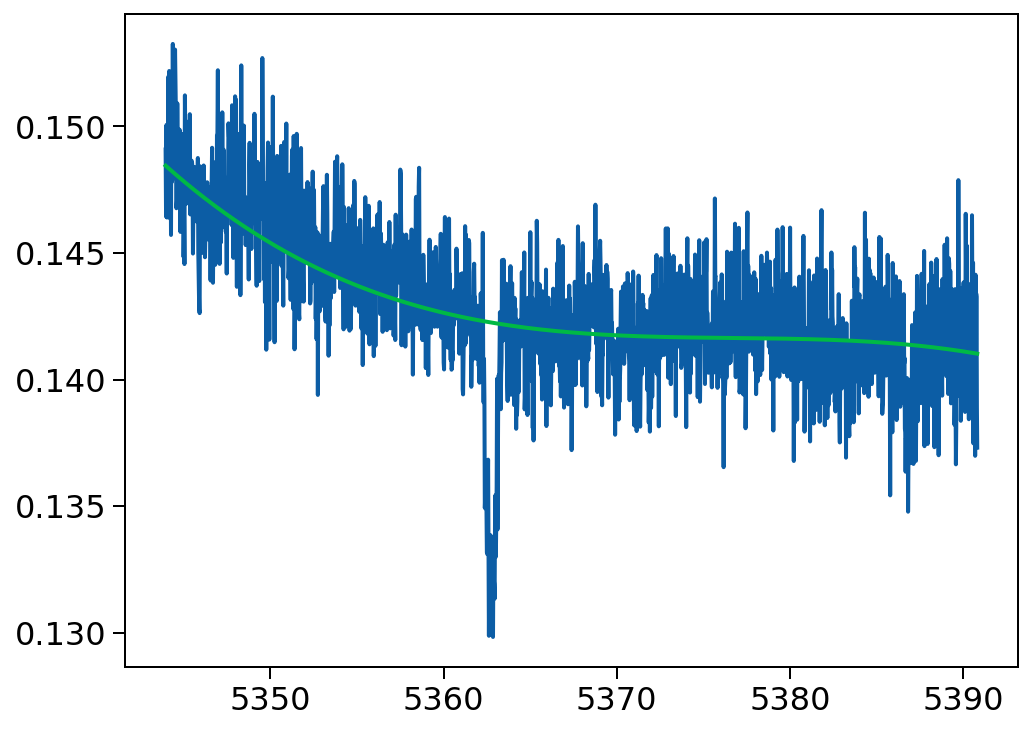

In [5]:
wav, flux = vs.get_order(0, 26)
m = flux < np.percentile(flux, 95)
p = np.polyfit(wav[m], flux[m], 3)

plt.plot(wav, flux)
plt.plot(wav, np.polyval(p, wav))

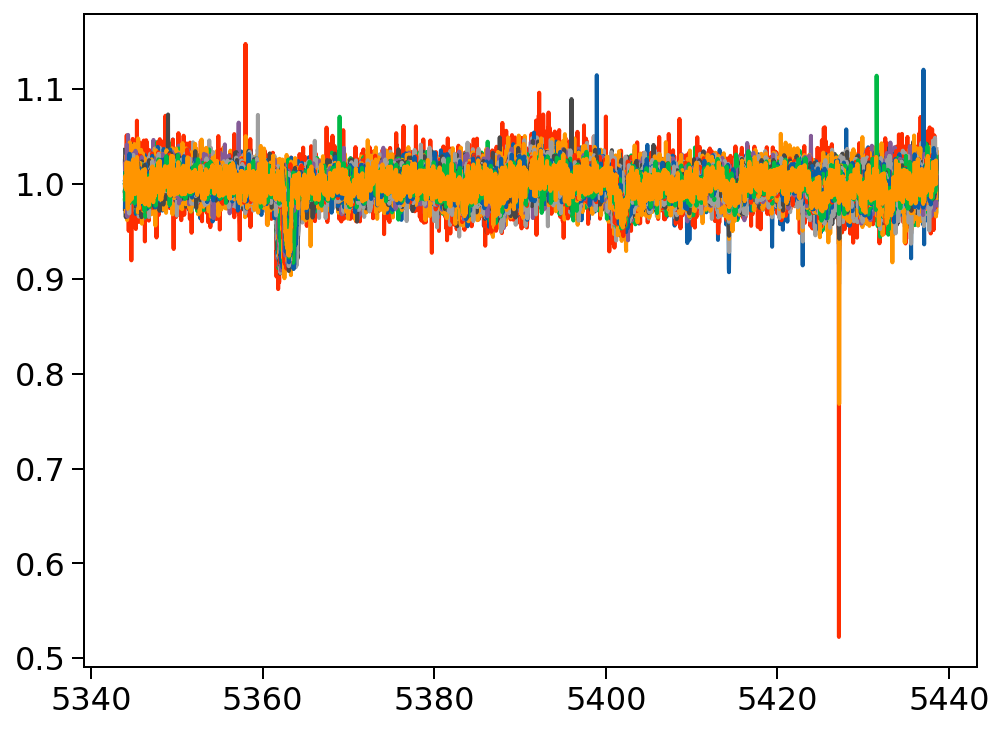

In [6]:
# epochs = np.arange(len(wav_shifts))
# m = ~((epochs == 60) | (epochs == 15))
# Best orders: 27, 26
wav, flux = vs.correct(orders=[26, 27],
                       smooth=0.)
plt.plot(wav, flux);
# plt.xlim(4950, 4960)

In [7]:
def interpolate_spectrum(x, y, int_wav=None, oversample=5):
    interp = []
    for x, y in zip(wav.T, flux.T):
        f1  = interpolate.interp1d(x, y, kind = 'linear')
        df = x[1] - x[0]
        if int_wav is None:
            int_wav = np.arange(x[0], x[-1], df / oversample)
        int_flux = f1(int_wav)
        interp.append(int_flux)
    return np.array(interp).T

In [8]:
# template = np.geomspace(wav.min()+3, wav.max()-3, 78895)
# template2 = np.exp(np.linspace(np.log(wav.min()+3), np.log(wav.max()-3), 78895))


In [9]:
# template = np.arange(wav.min()+3, wav.max()-3, 0.002)
template = np.geomspace(wav.min()+3, wav.max()-3, 78895)
interp = interpolate_spectrum(wav, flux, int_wav=template)

(5360.0, 5370.0)

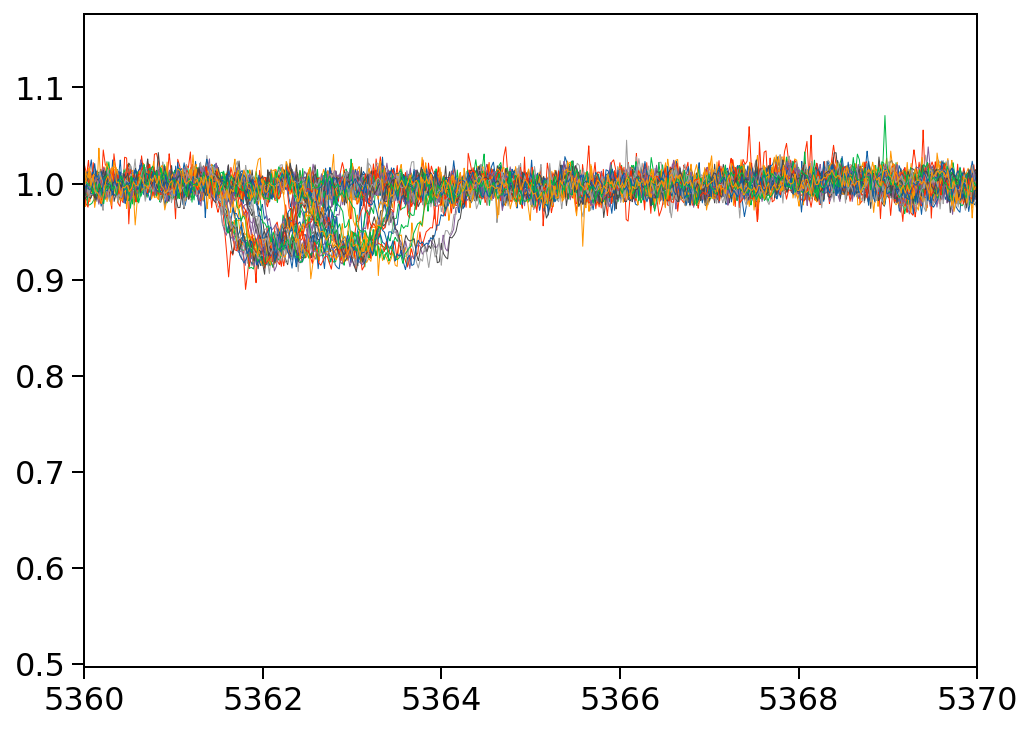

In [10]:
plt.plot(template, interp, lw=0.5);
plt.xlim(5360, 5370)

In [11]:
plt.style.use('notebook')

100%|██████████| 59/59 [01:10<00:00,  1.20s/it]


Text(0, 0.5, 'Rectified autocorrelation')

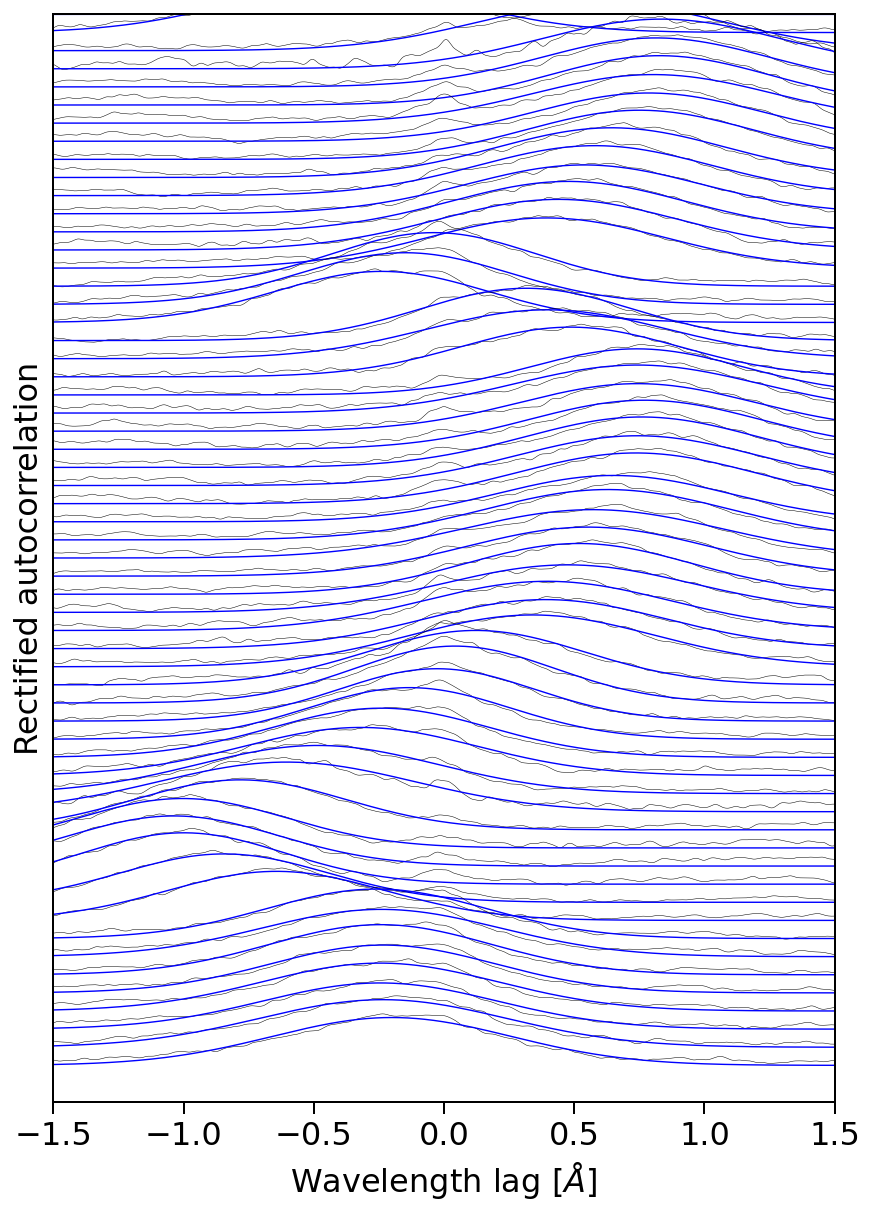

In [12]:
import tqdm

plt.figure(figsize=[7,10])

wav_shift_primary = []
for i, j in tqdm.tqdm(enumerate(interp.T[:]), total=len(interp.T)):
    acor = np.correlate(interp.T[0] - 1., j - 1., mode='full')
    df = template[1] - template[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    m3 = (lags < 2) & (lags > -2)
    
    x0 = [0.03, 0.1, lags[m3][np.argmax(acor[m3])]]
    res = fit_gaussian(lags[m3], acor[m3], x0)
    wav_shift_primary.append(res.x[-1])
    plt.plot(lags, acor - i*2, linewidth=0.25, c='black');
    plt.plot(lags, model(res.x, lags) - i*2, c='blue', lw=0.7)
    plt.xlim(-1.5, 1.5)
    
#     plt.show()
wav_shift_primary = np.array(wav_shift_primary)
plt.ylim(-120, 0)
plt.yticks([])
plt.xlabel(r'Wavelength lag [$\AA$]')
plt.ylabel('Rectified autocorrelation')

# plt.savefig('primary.png', dpi=300, transparent=True)

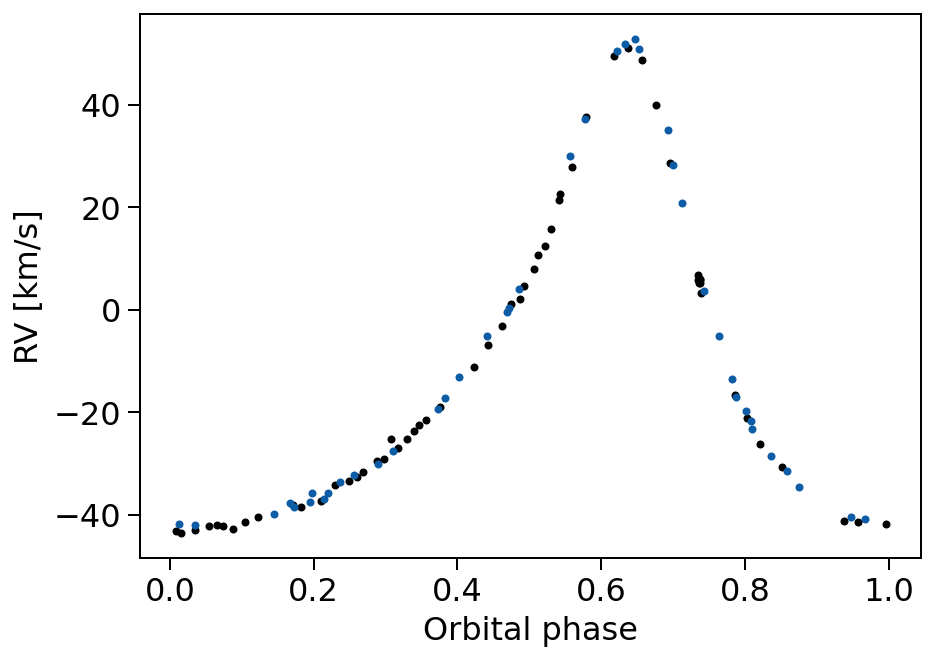

In [13]:
import astropy.units as u
plt.figure(figsize=[7,5])

bischoff_x, bischoff_y = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1)).T

bvcs = []
for meta in vs.meta:
    bvcs.append(meta['BVC'])
    
bvcs = np.array(bvcs)
obs_times = vs.observed_times()

RV = -1*(299792.458 * u.km / u.s) * ((wav_shift_primary) / np.mean(template)) 
RV = RV + (bvcs * u.km / u.s) + RV * (bvcs * u.km / u.s) / (299792.458 * u.km / u.s)

gv = 9
plt.plot((obs_times + 2400000) % porb / porb, RV.value - gv, '.k');
plt.plot((bischoff_x + 2457000) % porb / porb, bischoff_y, '.')

plt.xlabel('Orbital phase')
plt.ylabel('RV [km/s]')

RV_primary = RV

# plt.savefig('primary.png', pad_inches=0.1)

# Now the secondary

In [14]:
# wav_shifts = wav_shift

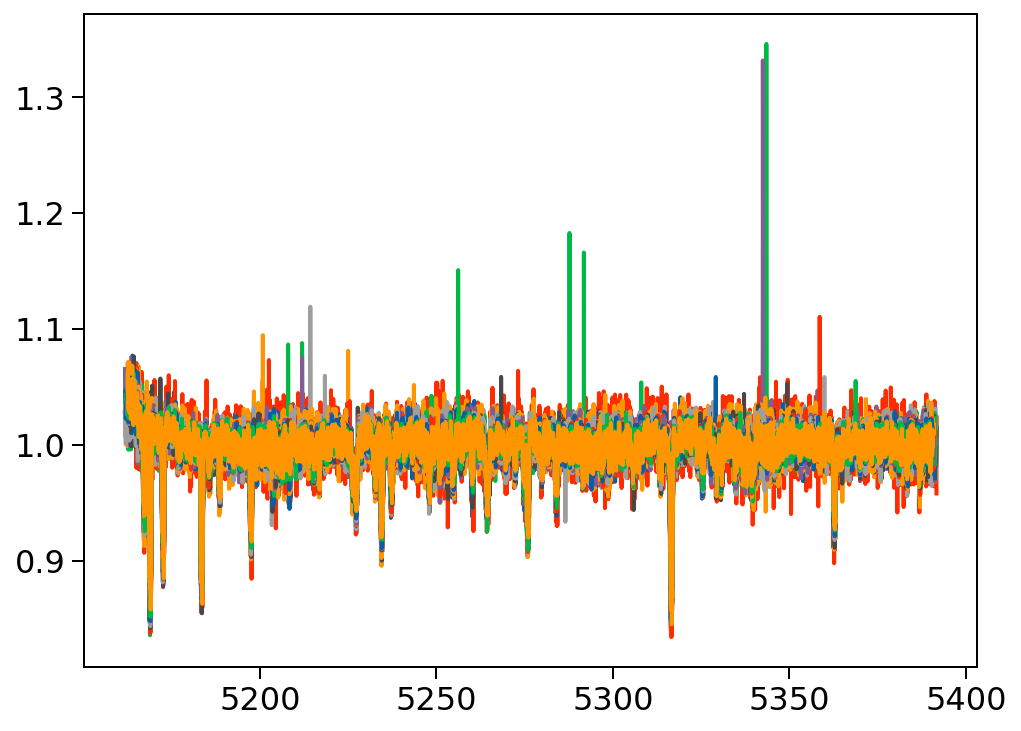

In [15]:
# epochs = np.arange(len(wav_shifts))
# m = ~((epochs == 60) | (epochs == 15))
# Best orders: 27, 26
wav, flux = vs.correct(orders=[22,23,24,25,26], 
                       offset=-1*wav_shift_primary, 
                       smooth=0.015)
plt.plot(wav, flux);
# plt.xlim(5360, 5370)

Text(0, 0.5, 'Flux')

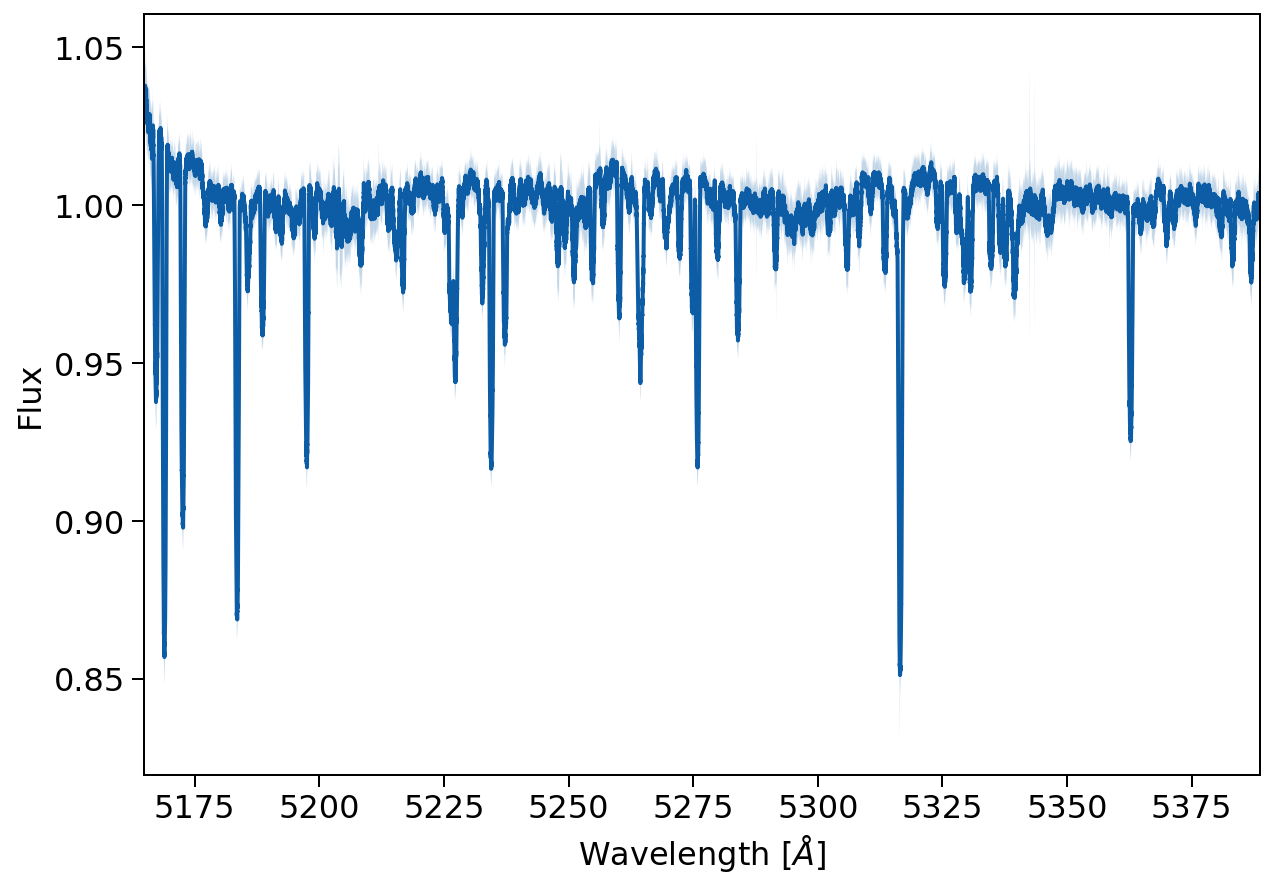

In [16]:
# template = np.arange(wav.min()+3, wav.max()-3, 0.0025)
plt.figure(figsize=[10,7])

template = np.geomspace(wav.min()+3, wav.max()-3, 78895)

interp = vs.interpolate(wav, flux, template)
med_primary = np.median(interp, axis=1)
sd_primary = np.std(interp, axis=1)
plt.plot(template, med_primary)
plt.fill_between(template, med_primary-sd_primary, med_primary+sd_primary, alpha=0.25)

plt.xlim(template.min(), template.max())
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')
# plt.xlim(5400, 5410)
# plt.savefig('primary_template.png', pad_inches=0.1)

In [17]:
times = vs.observed_times()#[m]

phase = times % porb / porb
sort = np.argsort(phase)

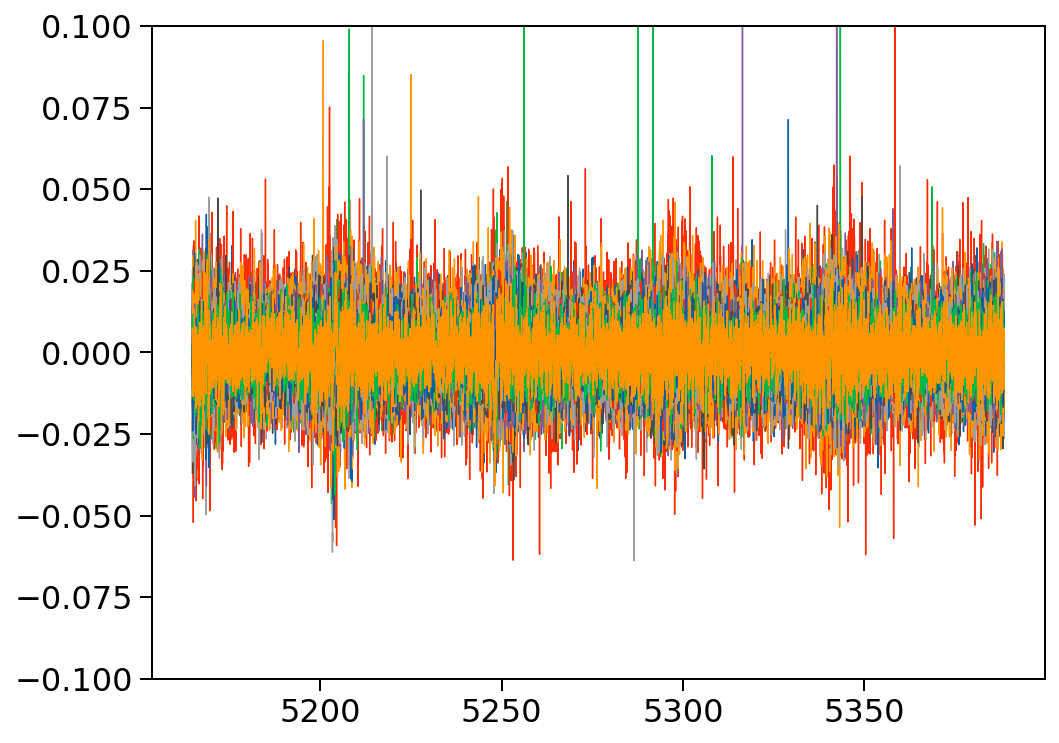

In [18]:
for i, j in enumerate(interp.T[:]):
#     plt.plot(template, j)
#     plt.plot(template, med)
    
    plt.plot(template, j - med_primary, lw=0.7);
#     plt.xlim(5400, 5410)
    plt.ylim(-0.1, 0.1)
#     acor = np.correlate(interp.T[0] - med, j - med, mode='full')

In [19]:
1-0.025

0.975

Text(0, 0.5, 'Rectified autocorrelation')

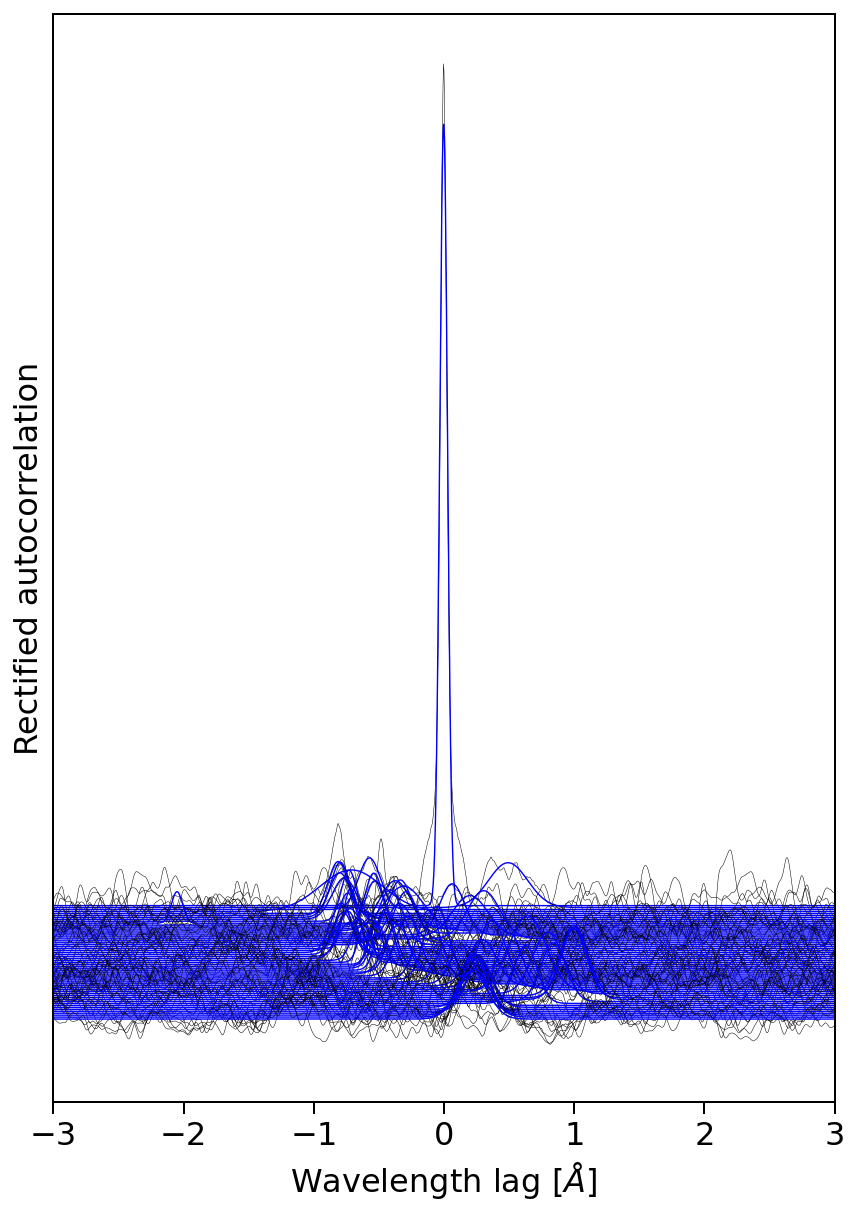

In [20]:
plt.figure(figsize=[7,10])

wav_shift_secondary = []
for i, j in enumerate(interp.T[:]):
    acor = np.correlate(interp.T[0] - med_primary, j - med_primary, mode='full')
    df = template[1] - template[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    m3 = (lags < 4) & (lags > -4)
    
    x0 = [0.03, 0.1, lags[m3][np.argmax(acor[m3])]]
    res = fit_gaussian(lags, acor, x0)
    wav_shift_secondary.append(res.x[-1])
    plt.plot(lags, acor - i*0.015, linewidth=0.25, c='black');
    plt.plot(lags, model(res.x, lags) - i*0.015, c='blue', lw=0.7)
    plt.xlim(-3, 3)
    
#     plt.show()
wav_shift_secondary = np.array(wav_shift_secondary)
plt.yticks([])
plt.xlabel(r'Wavelength lag [$\AA$]')
plt.ylabel('Rectified autocorrelation')

# plt.savefig('secondary.png', dpi=300, transparent=True)

In [21]:
bvcs = []
for meta in vs.meta:
    bvcs.append(meta['BVC'])
    
bvcs = np.array(bvcs)

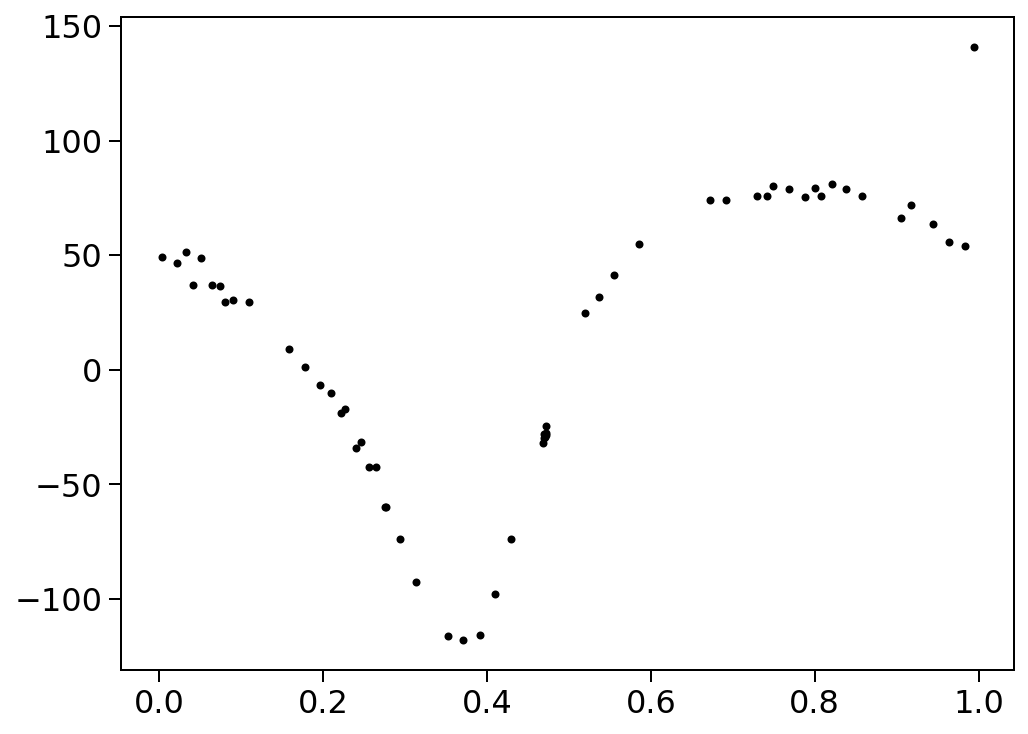

In [22]:
import astropy.units as u

RV = (299792.458 * u.km / u.s) * ((wav_shift_primary - wav_shift_secondary) / np.mean(template)) 
# RV = (299792.458 * u.km / u.s) * ((0 - wav_shift_secondary) / np.mean(template)) 
RV = RV - (bvcs * u.km / u.s) - RV * (bvcs * u.km / u.s) / (299792.458 * u.km / u.s)

plt.plot(obs_times % porb / porb, RV, '.k');
RV_secondary = RV

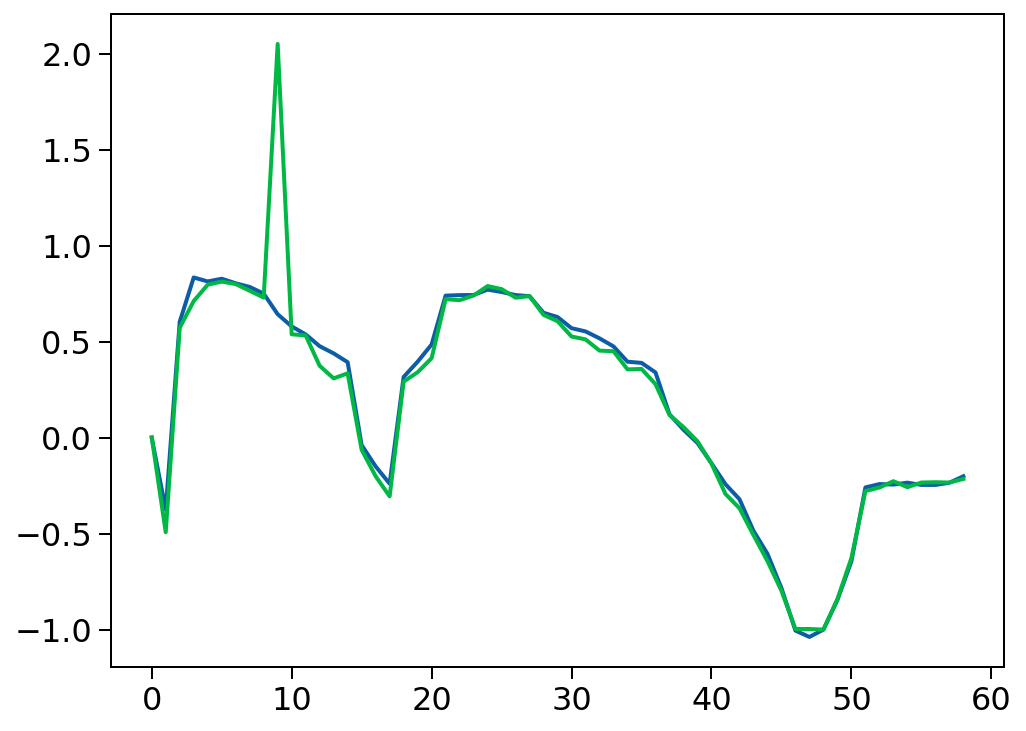

In [23]:
plt.plot(wav_shift_primary)
plt.plot(-1*wav_shift_secondary)

(0.0, 1.0)

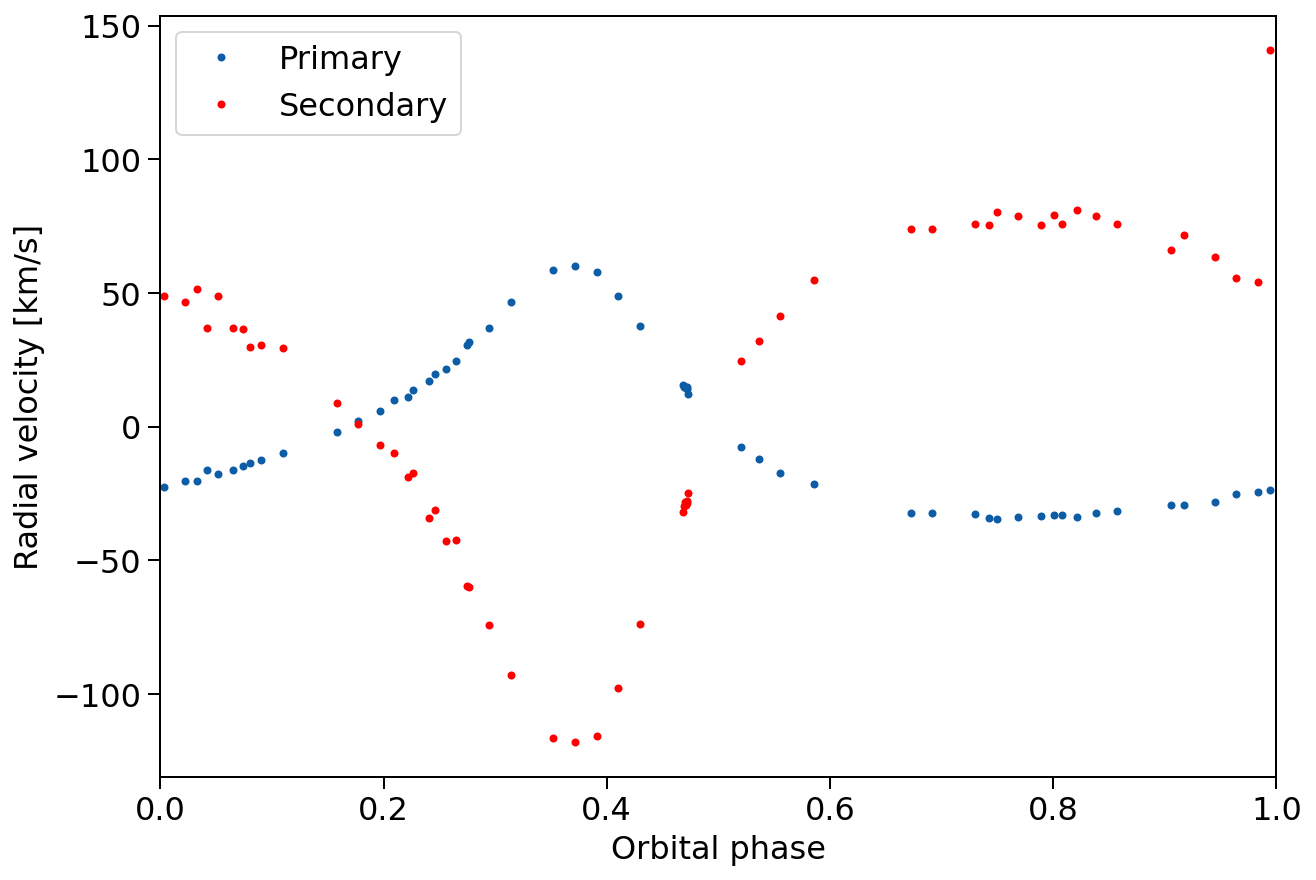

In [24]:
plt.figure(figsize=[10,7])

plt.plot(obs_times % porb / porb, RV_primary, '.', c='C0', label='Primary')
plt.plot(obs_times % porb / porb, RV_secondary, '.', c='red', label='Secondary')

plt.xlabel('Orbital phase')
plt.ylabel('Radial velocity [km/s]')
plt.legend()
plt.xlim(0,1)
# plt.savefig('both_rv.png', dpi=300, transparent=True)

In [34]:
# t_primary, rv_primary, err_primary = np.loadtxt('data/RV/SONG.txt', usecols=(0,1,2)).T

In [35]:
# plt.errorbar(t_primary % porb / porb, rv_primary,yerr=err_primary, fmt='.', label='Primary', c='C0')
# plt.plot(obs_times % porb / porb, RV, '.', label='Secondary', c='C3')
# plt.legend()

# plt.xlabel('Phase')
# plt.ylabel('RV [km/s]')

# # plt.savefig('nice.png', dpi=300, bbox_inches='tight')

In [36]:
# fig, ax = plt.subplots(figsize=[7,12])

# wav_shift = []
# for i, j in enumerate(interp.T[1:]):
#     acor = np.correlate(interp.T[0] - med, j - med, mode='full')
#     df = template[1] - template[0]
#     lags = df*np.arange(-len(acor)//2, len(acor)//2)
#     m3 = (lags < 2) & (lags > -2)
    
#     x0 = [0.03, 0.1, lags[m3][np.argmax(acor[m3])]]
#     res = fit_gaussian(lags, acor, x0)
#     wav_shift.append(res.x[-1])
#     ax.plot(lags, acor - i*0.02, linewidth=0.7, c='white');
# #     plt.plot(lags, model(res.x, lags) - i*0.015, c='blue', lw=0.7)
#     ax.set_xlim(-1.5, 1.5)
    
# #     plt.show()
# wav_shift = np.array(wav_shift)
# ax.set_facecolor('black')
# # plt.axis('off')

# plt.savefig('secondary_plot.png', dpi=600, pad_inches=0.)
# # plt.xlabel(r'Wavelength cross correlation [$\AA$]')
# # plt.ylabel('Rectified flux')

# # plt.savefig('secondary.png', pad_inches=0.1)

In [16]:
np.savetxt('data/RV/SONG_secondary.txt', list(zip(obs_times, RV.value)))

In [22]:
0.5*np.max(rv_primary)/(0.5*np.max(RV))

<Quantity 0.67468638 s / km>

In [20]:
0.5*np.max(RV), 

(<Quantity 41.84033092 km / s>,)

In [23]:
0.67 * 1.5

1.0050000000000001

# Can we see the secondary lines with careful alignment and stacking?

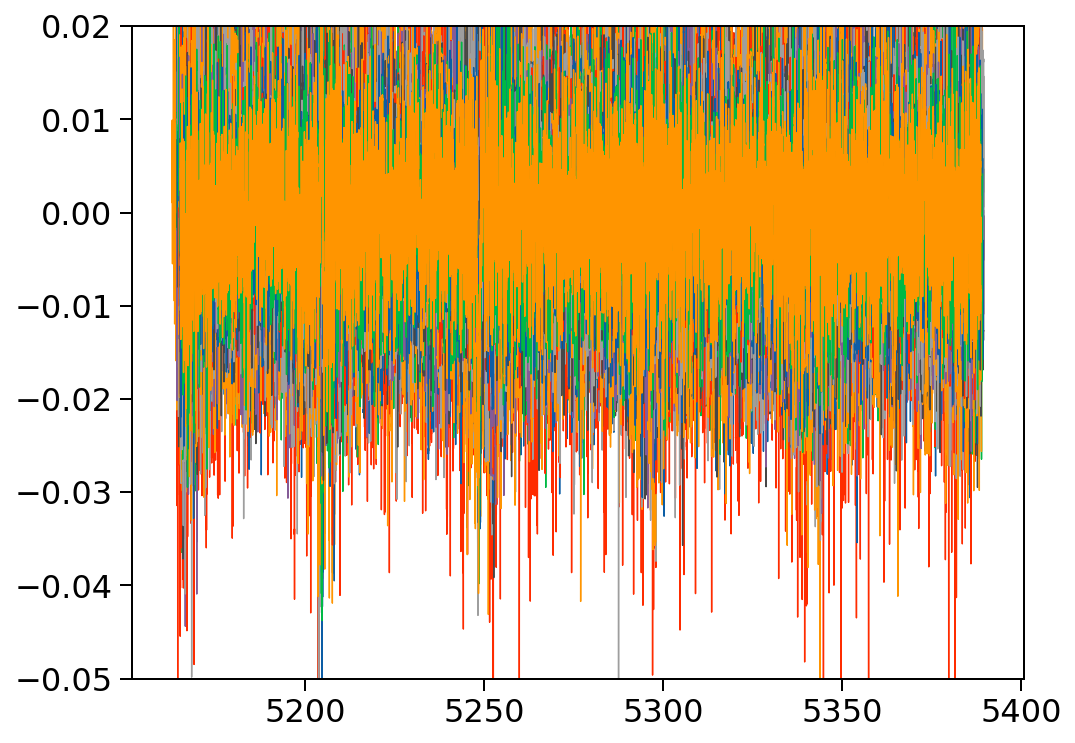

In [34]:
template2 = np.geomspace(5166, 5385, 78895)
for i, j in enumerate(interp.T[:]):
    subtracted = j - med_primary
    plt.plot(template + wav_shift_secondary[i], j - med_primary, lw=0.7,);
    plt.ylim(-0.05, 0.02)
#     plt.plot(template, j - med_primary);
#     acor = np.correlate(interp.T[0] - med_primary, j - med_primary, mode='full')

In [35]:
template.shape

(78895,)

(5350.0, 5375.0)

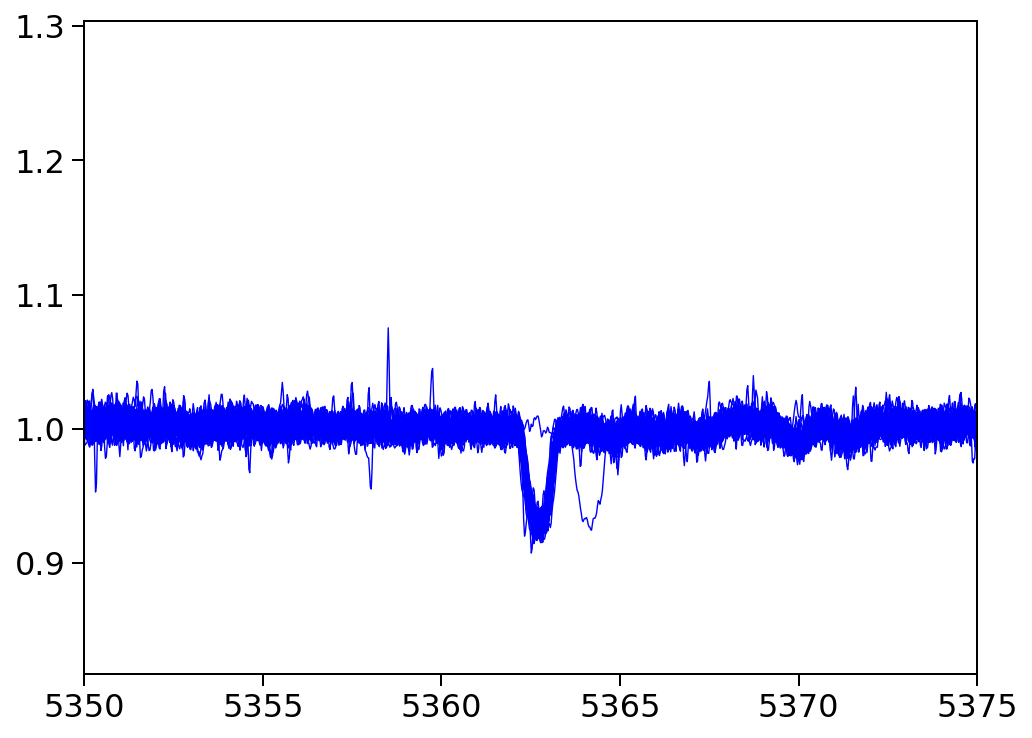

In [41]:
wav, flux = vs.correct(orders=[23,24,25,26], 
                       offset=wav_shift_secondary, 
                       smooth=0.025)
plt.plot(wav, flux, lw=0.7, c='blue');
plt.xlim(5350, 5375)

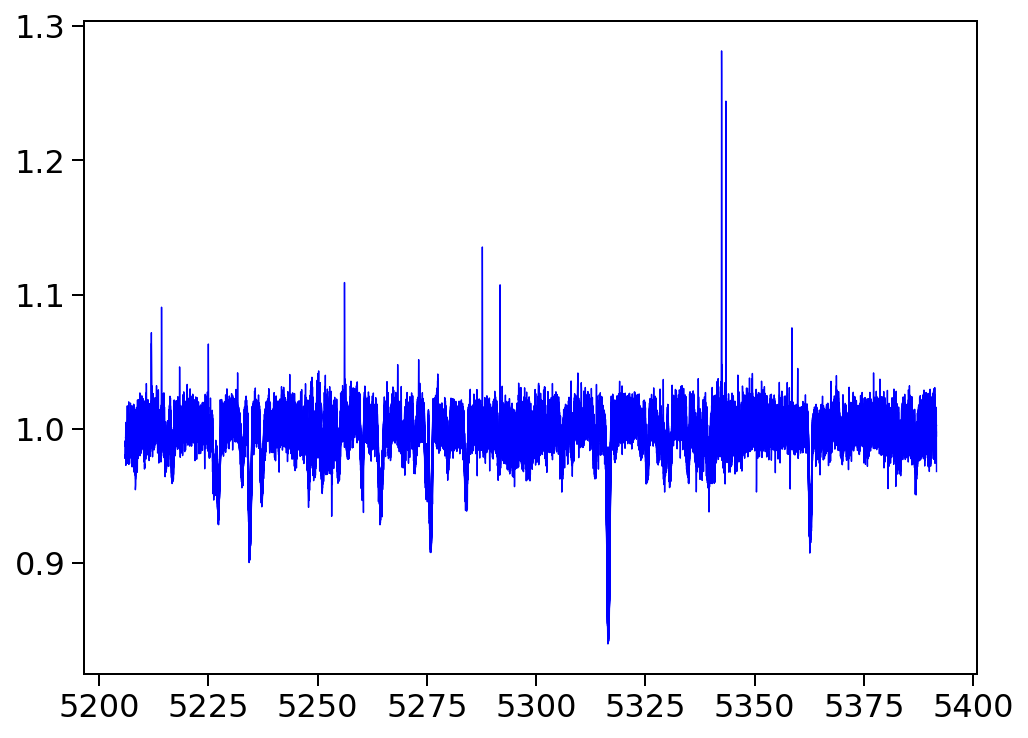

In [39]:
wav, flux = vs.correct(orders=[23,24,25,26], 
                       offset=-1*wav_shift_primary, 
                       smooth=0.025)
plt.plot(wav, flux, lw=0.7, c='blue');

In [42]:
# template = np.arange(wav.min()+3, wav.max()-3, 0.0025)
# template = np.arange(wav.min()+3, wav.max()-3, 0.025)
template = np.geomspace(wav.min()+3, wav.max()-3, 78895)

interp = vs.interpolate(wav, flux, template)
med_secondary = np.median(interp, axis=1)
sd_secondary = np.std(interp, axis=1)

plt.plot(template, med_secondary, c='blue', lw=0.7)
plt.plot(template, med_primary, c='red', lw=0.7)
# plt.fill_between(template, med_secondary-sd_secondary, med_secondary+sd_secondary, alpha=0.5, color='blue')
# plt.fill_between(template, med_primary-sd_primary, med_primary+sd_primary, alpha=0.5, color='red')

# plt.xlim(, 5410)

ValueError: A value in x_new is below the interpolation range.

In [41]:
wav_shift_sec = np.array([-0.02500001,  0.3250416 , -0.64507536, -0.82973532, -0.78925908,
       -0.80426134, -0.7972862 , -0.7859665 , -0.72141825, -0.63434982,
       -0.58237375, -0.5396525 , -0.42481366, -0.39157843, -0.3509249 ,
        0.03526773,  0.1326431 ,  0.24435943, -0.3188677 , -0.4066935 ,
       -0.48440467, -0.71984082, -0.72571707, -0.72996784, -0.76912592,
       -0.76089694, -0.76100036, -0.75377993, -0.67410517, -0.60748008,
       -0.57669343, -0.55614199, -0.4957807 , -0.50431566, -0.44904576,
       -0.36813501, -0.3837122 , -0.14122419, -0.08054688,  0.01854676,
        0.12941844,  0.24699535,  0.33393744,  0.44420313,  0.57349685,
        0.73047875,  0.91763246,  0.96480103,  0.91134486,  0.79285758,
        0.61260371,  0.25280333,  0.23873221,  0.21917675,  0.24642703,
        0.24107497,  0.21130634,  1.03882714,  0.17516256])

In [42]:
sec_wav, sec_flux = [], []
for shift, inter in zip(wav_shift_sec, interp.T):
    sec_wav.append(template - shift)
    sec_flux.append(inter - med)
sec_wav, sec_flux = np.array(sec_wav).T, np.array(sec_flux).T

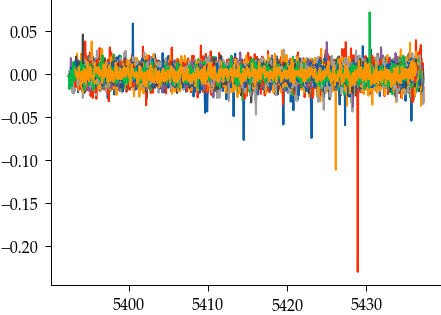

In [43]:
plt.plot(sec_wav, sec_flux);

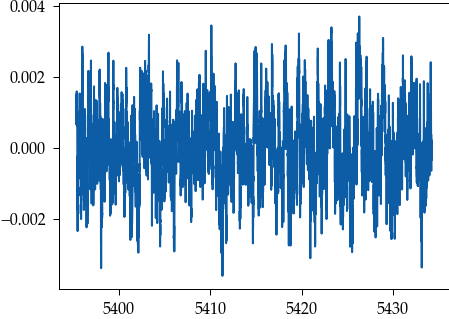

In [44]:
template = np.arange(sec_wav.min()+3, sec_wav.max()-3, 0.0025)
interp = vs.interpolate(sec_wav, sec_flux, template)
med = np.median(interp, axis=1)
plt.plot(template, med)
# plt.xlim(5200, 5250)

# Synthetic spectrum from Richard

In [150]:
plt.style.use('notebook')

In [151]:
synth_spec = 'data/Spectra/SOPHIE/SS_AlphaDra_final_4400_4600.norm'
synth_wav, synth_flux = np.loadtxt(synth_spec, usecols=(0,1)).T

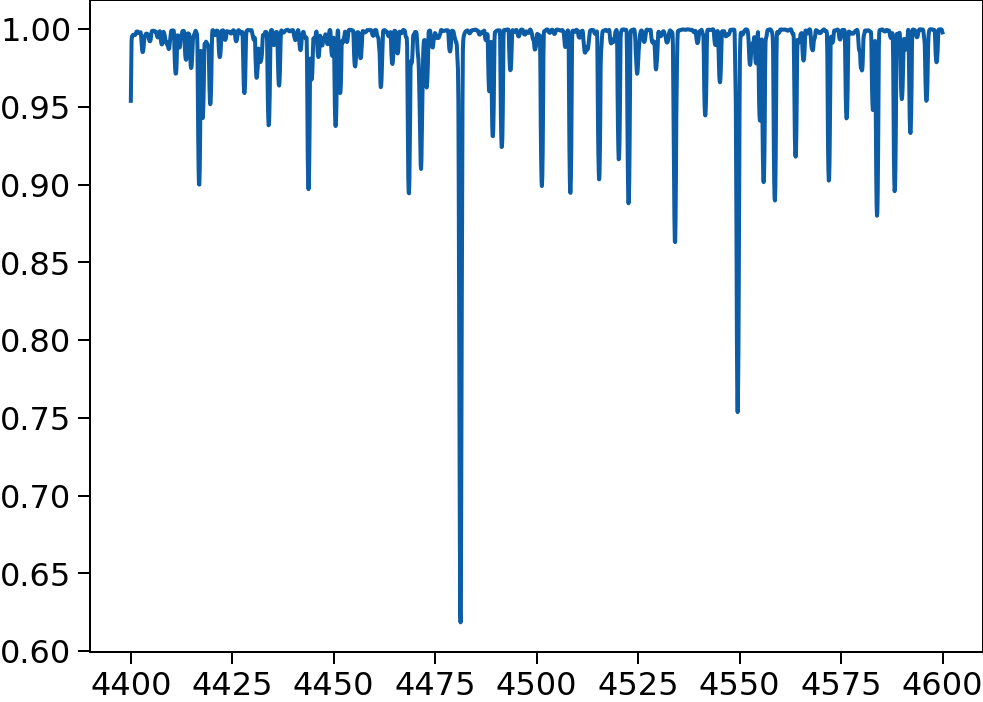

In [152]:
plt.plot(synth_wav, synth_flux)

/Users/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


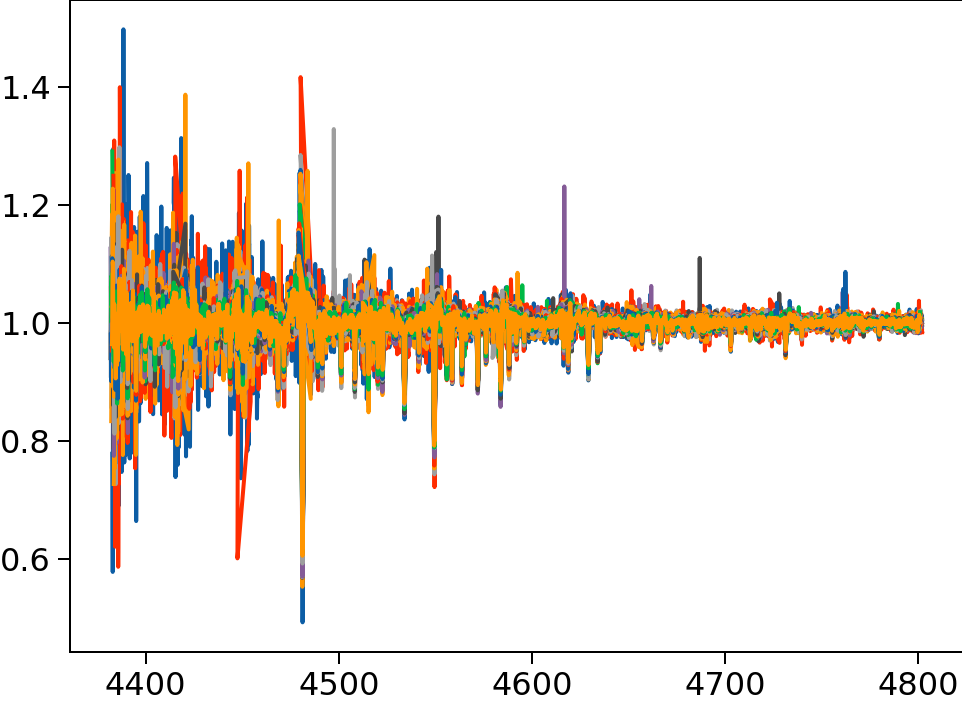

In [153]:
all_spectra_files = np.array(sorted(glob.glob(spectra_dir + '*.fits')))

epochs = np.arange(len(all_spectra_files))
m = ~((epochs == 60) | (epochs == 15))
# m = np.ones_like(epochs, dtype=bool)

vs = Verse.get_spectra(all_spectra_files[m])

wav, flux = vs.correct(orders=[1,2,3,4,5,6,7,8,9,10,11,12], 
                       offset=wav_shifts, 
                       smooth=0.1,
                      flatten=20, k=5)
plt.plot(wav, flux);
# plt.xlim(4950, 4960)

Text(0, 0.5, 'Flux')

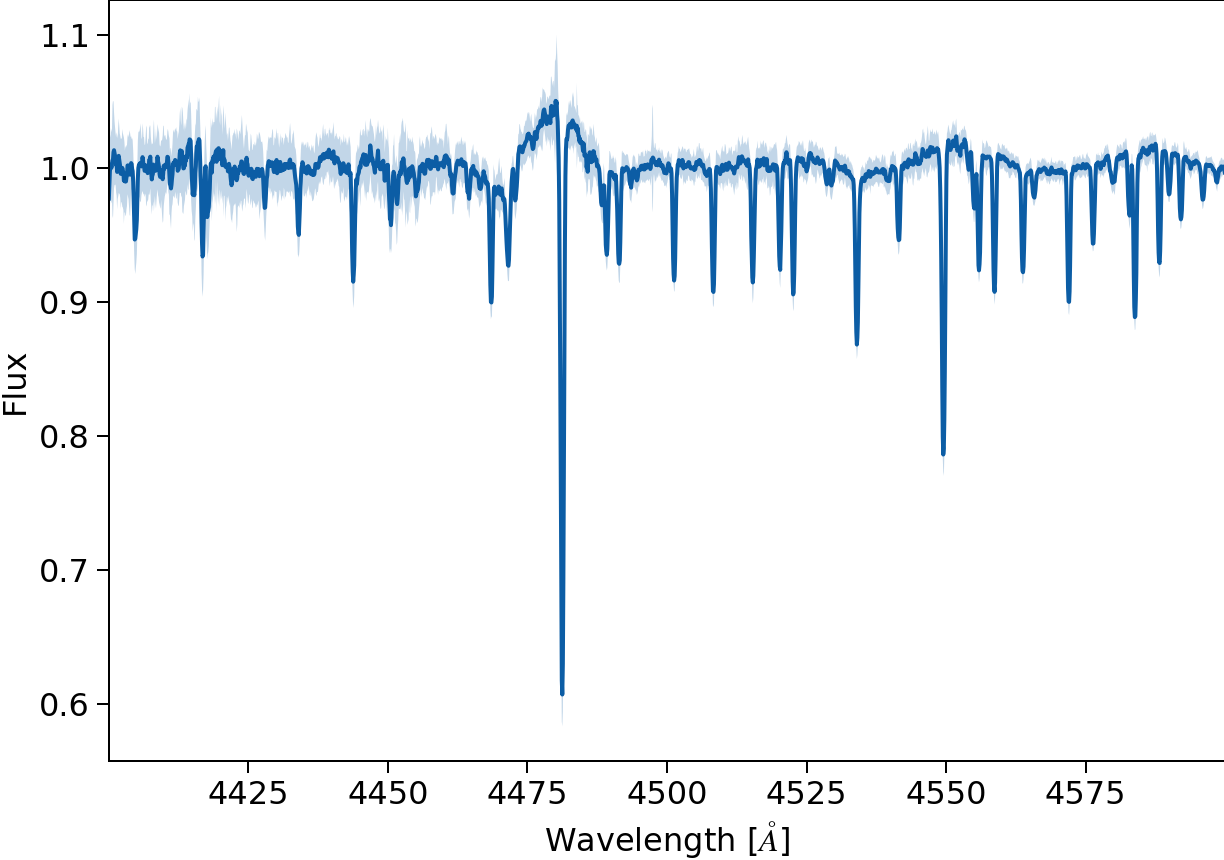

In [154]:
# template = np.arange(wav.min()+3, wav.max()-3, 0.0025)
plt.figure(figsize=[10,7])

template = synth_wav#np.arange(wav.min()+3, wav.max()-3, 0.02)
interp = vs.interpolate(wav, flux, template)
med = np.median(interp, axis=1)
sd = np.std(interp, axis=1)
plt.plot(template, med)
plt.fill_between(template, med-sd, med+sd, alpha=0.25)

plt.xlim(template.min(), template.max())
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

# plt.savefig('primary_template.png', pad_inches=0.1)

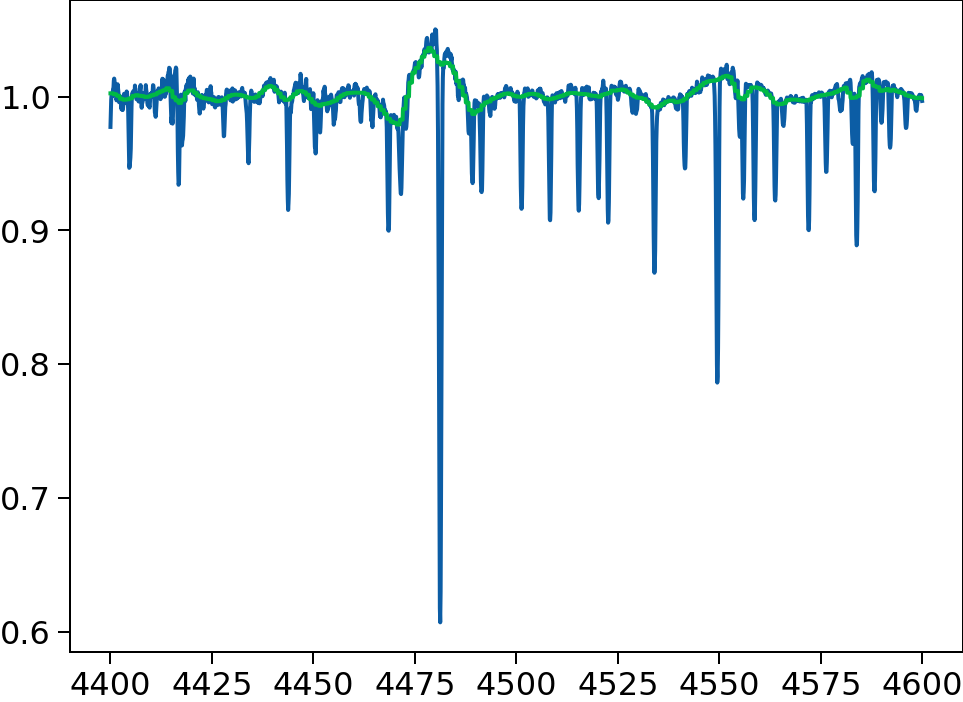

In [155]:
def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

bkg = estimate_background(synth_wav, med, log_width=0.00015)

plt.plot(synth_wav, med)
plt.plot(synth_wav, bkg)
# flat = vs.flatten(synth_wav, med, k=5, s=100)
# plt.plot(synth_wav, flat)

(4400.02, 4599.95)

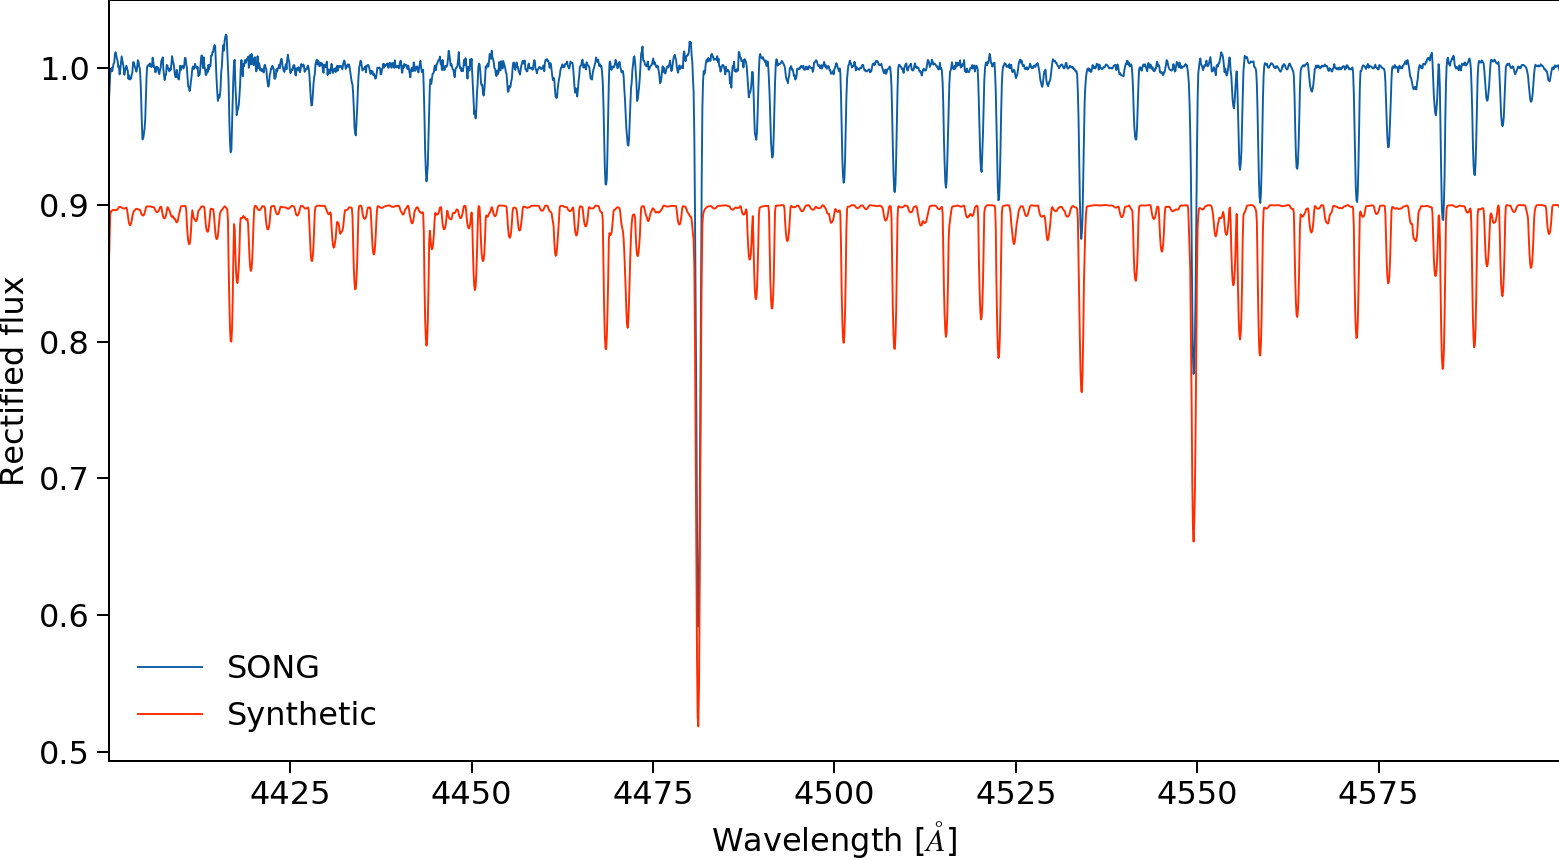

In [162]:
plt.figure(figsize=[13,7])

plt.plot(synth_wav, med / bkg, alpha=1, lw=0.95, c='C0', label='SONG')
plt.plot(synth_wav, synth_flux - 0.1, alpha=1, lw=0.95, c='C3', label='Synthetic')
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel('Rectified flux')
plt.legend()

plt.xlim(synth_wav[0], synth_wav[-1])

# plt.xlim(4475, 4500)
# plt.savefig('song_comparme_synthetic.png', dpi=300, bbox_inches='tight')

# Cross corr with synthetic spectrum

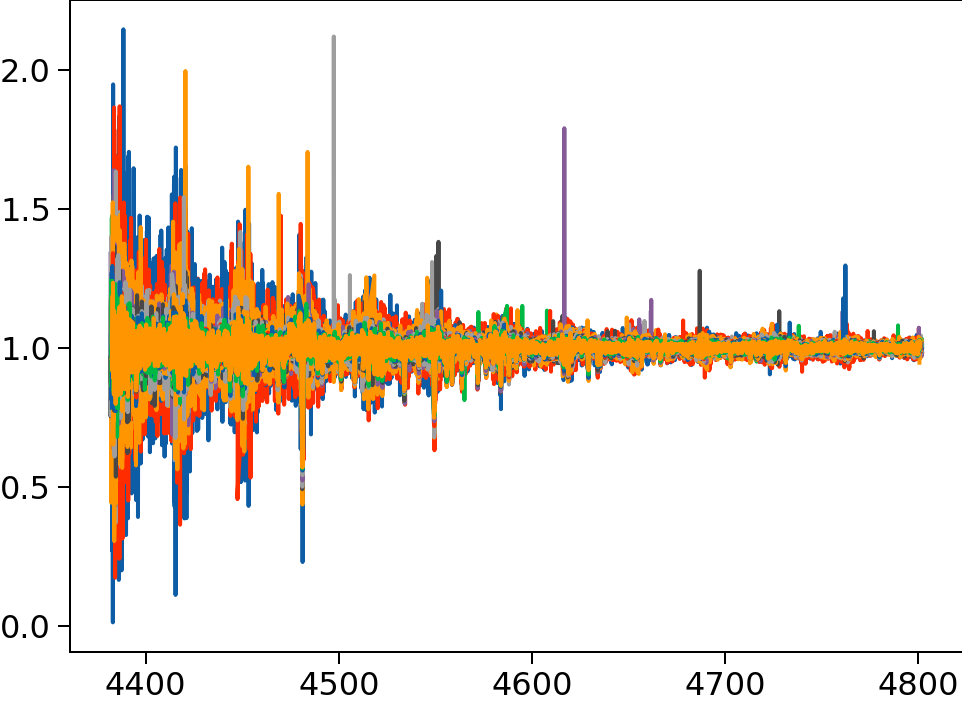

In [192]:
wav, flux = vs.correct(orders=[1,2,3,4,5,6,7,8,9,10,11,12], 
                       offset=wav_shifts, 
                       smooth=0.025)
plt.plot(wav, flux);

(4400.02, 4599.95)

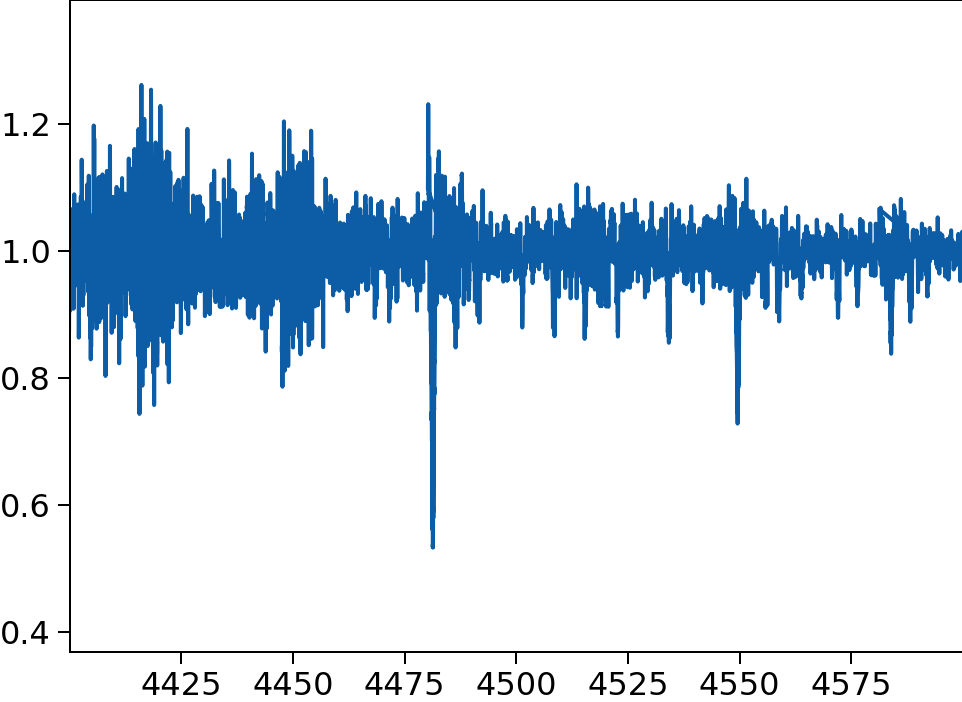

In [198]:
bkg = estimate_background(wav[:,7], flux[:,7], log_width=0.00015)
plt.plot(wav[:,7], flux[:,7] / bkg)
plt.xlim(synth_wav[0], synth_wav[-1])
# plt.plot(synth_wav, synth_flux)


In [194]:
from scipy import interpolate

def interpolate_spec(x, y, template_wav):
    f1  = interpolate.interp1d(x, y, kind = 'linear')
    df = x[1] - x[0]
    int_flux = f1(template_wav)
    return int_flux

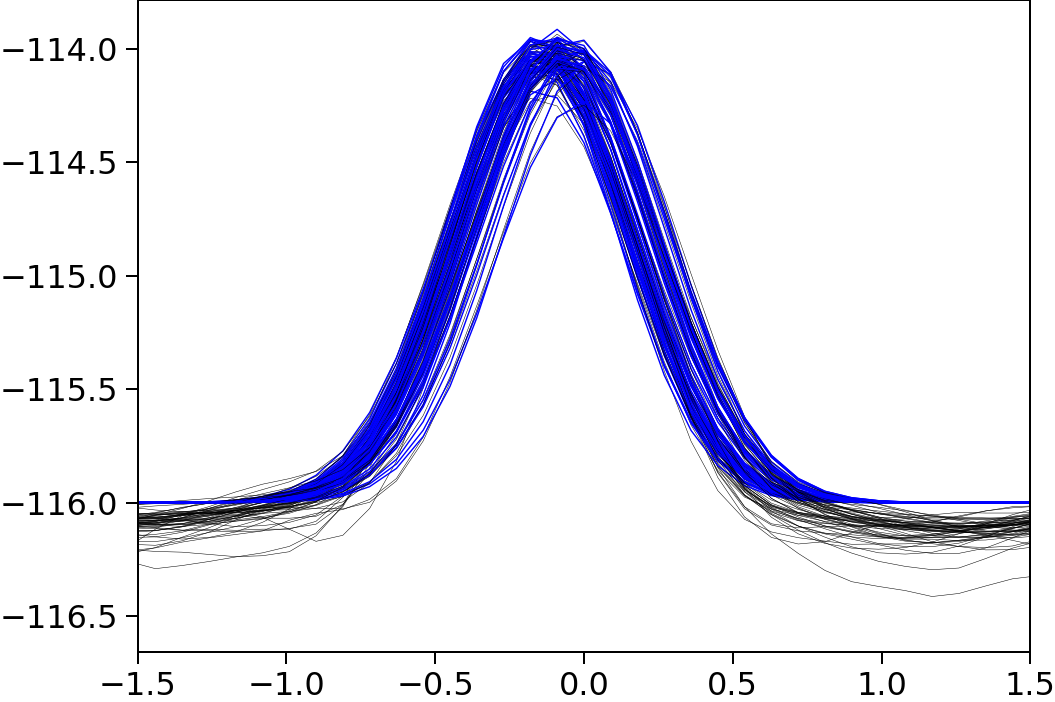

In [195]:
wav_shift = []
for w, f in zip(wav.T, flux.T):
    # Interpolate to template
    interp = interpolate_spec(w, f, synth_wav)
    bkg = estimate_background(synth_wav, interp, log_width=0.00015)
    
    # Correlate:
    acor = np.correlate(synth_flux - 1., (interp / bkg) - 1., mode='full')
    df = template[1] - template[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    m3 = (lags < 2) & (lags > -2)
    
    x0 = [0.03, 0.1, lags[m3][np.argmax(acor[m3])]]
    res = fit_gaussian(lags, acor, x0)
    wav_shift.append(res.x[-1])
    plt.plot(lags, acor - i*2, linewidth=0.25, c='black');
    plt.plot(lags, model(res.x, lags) - i*2, c='blue', lw=0.7)
    plt.xlim(-1.5, 1.5)

In [ ]:
import tqdm

plt.figure(figsize=[7,10])

wav_shift = []
for i, j in tqdm.tqdm(enumerate(wav.T[:]), total=len(wav.T)):
    # Interpolate spec flux:
    interp = vs.interpolate()
    acor = np.correlate(synth_flux - 1., j - 1., mode='full')
    df = template[1] - template[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    m3 = (lags < 2) & (lags > -2)
    
    x0 = [0.03, 0.1, lags[m3][np.argmax(acor[m3])]]
    res = fit_gaussian(lags, acor, x0)
    wav_shift.append(res.x[-1])
    plt.plot(lags, acor - i*2, linewidth=0.25, c='black');
    plt.plot(lags, model(res.x, lags) - i*2, c='blue', lw=0.7)
    plt.xlim(-1.5, 1.5)
    
#     plt.show()
wav_shift = np.array(wav_shift)

plt.xlabel(r'Wavelength acor [$\AA$]')
plt.ylabel('Rectified flux')

In [125]:
synth_wav[1] - synth_wav[0]

0.08999999999923602

In [ ]:
plt.figure(figsize=[5,15])

for i, j in enumerate(interp.T[sort]):
    acor = np.correlate(interp.T[0] - med, j - med, mode='full')
    df = template[1] - template[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    plt.plot(lags, acor - i*0.01, linewidth=0.7, c='black');
    
plt.xlim(-2.5,2.5)
plt.axvline(0., c='r', linestyle='dashed', lw=0.7)

plt.xlabel('Correlation wavelength [A]')
plt.ylabel('Rectified flux')
# plt.savefig('secondary2.png', dpi=300, bbox_inches='tight')

(-2.5, 2.5)

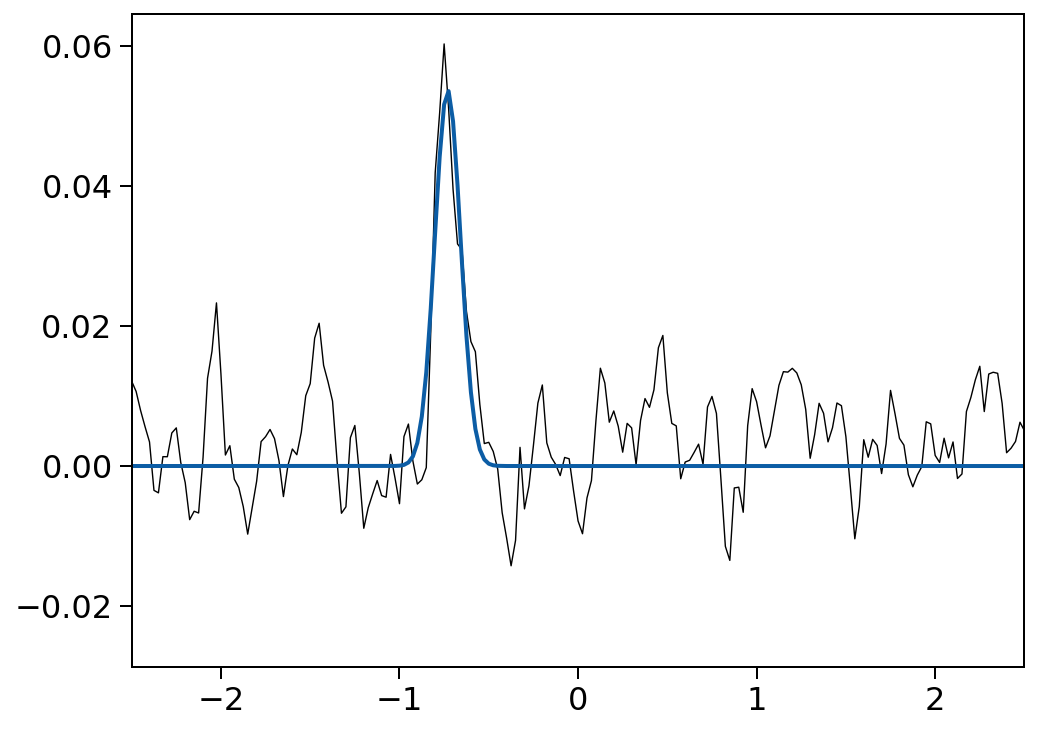

In [56]:
m3 = (lags < 2.5) & (lags > -2.5)
x0 = [0.03, 0.1, lags[m3][np.argmax(acor[m3])]]
res = fit_gaussian(lags, acor, x0)

plt.plot(lags, acor, linewidth=0.7, c='black');
plt.plot(lags, model(res.x, lags))
plt.xlim(-2.5, 2.5)

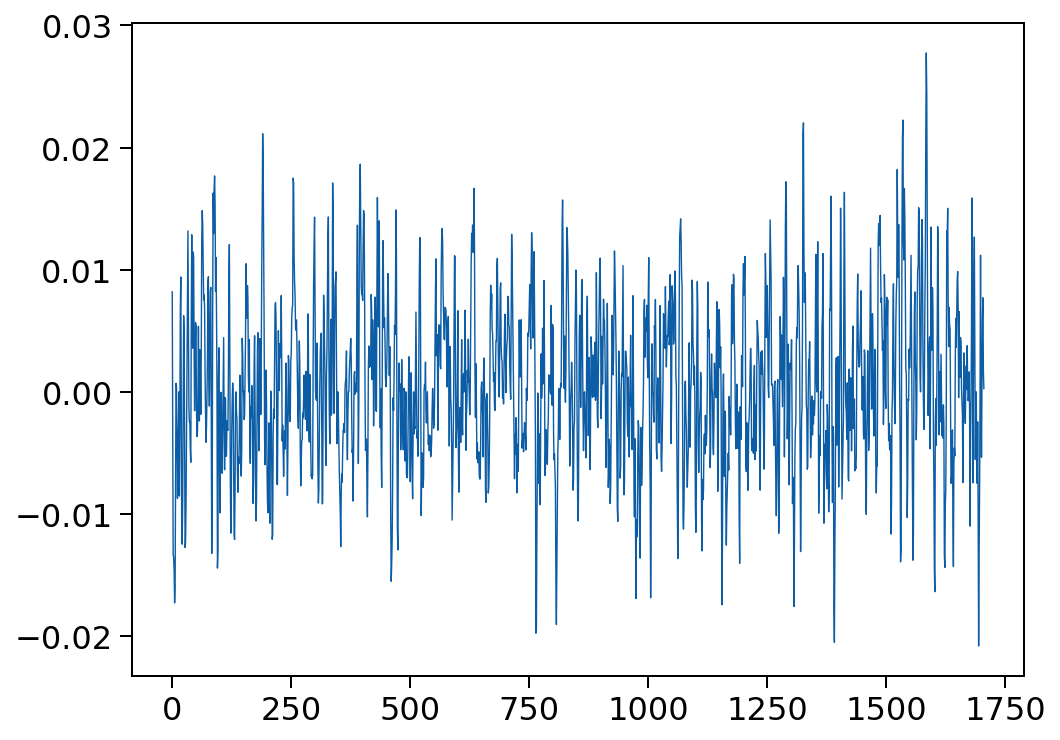

In [119]:
plt.plot(interp.T[20]-med, lw=0.7)
# plt.plot((med - 1) / np.max(, lw=0.7)

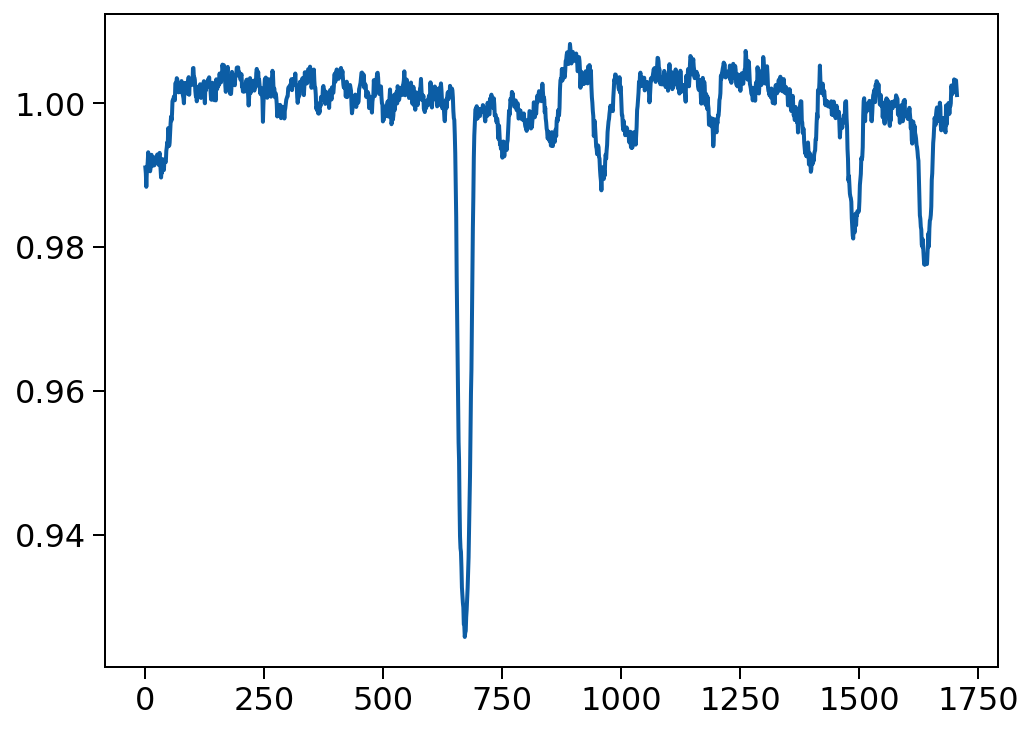

In [120]:
plt.plot(med)

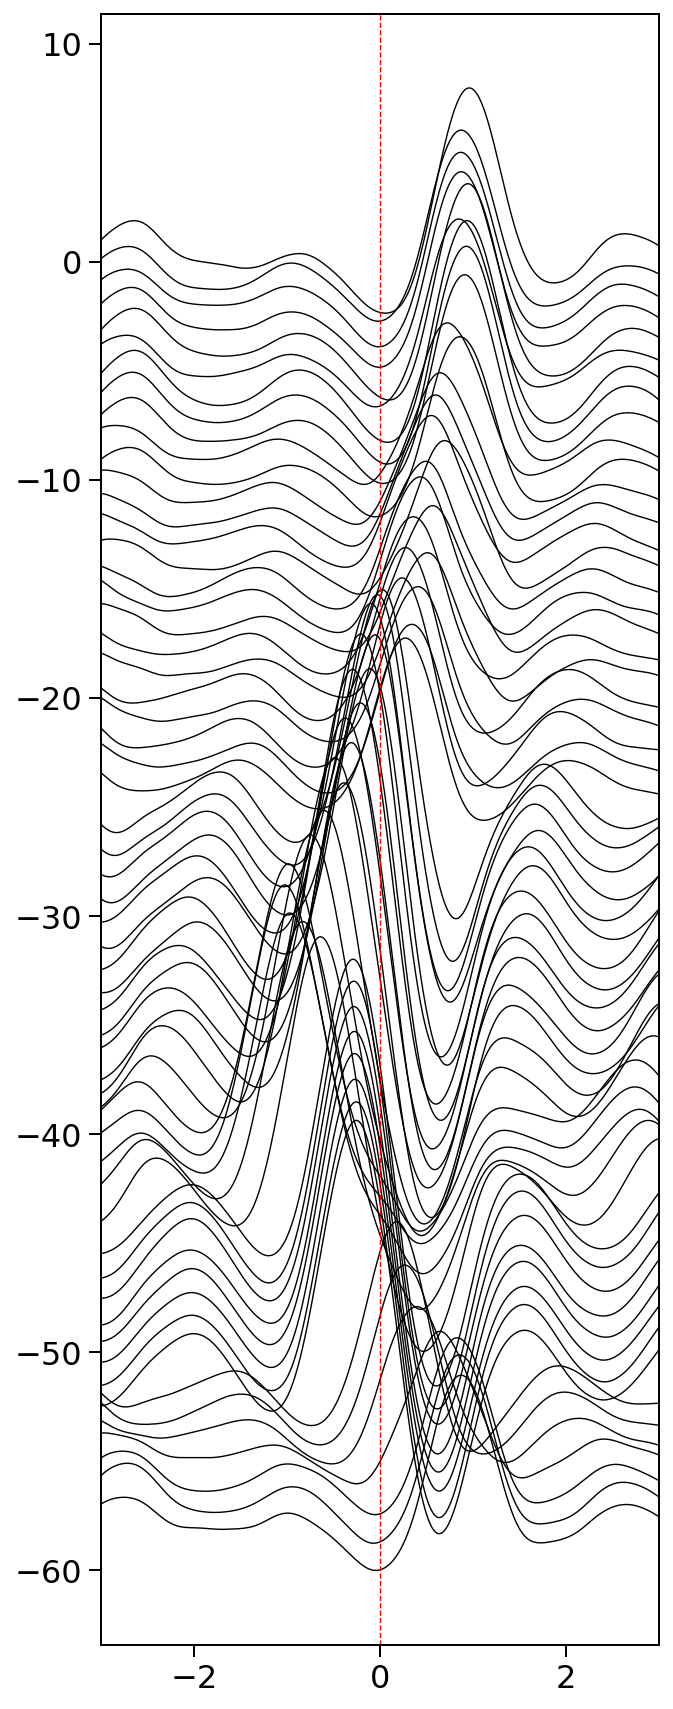

In [29]:
epochs = np.arange(len(wav_shifts))
m = ~((epochs == 60) | (epochs == 15))
wav, flux = vs.correct(epochs=epochs[m], orders=[22], 
#                        offset=wav_shifts[m], 
                       smooth=0.1)
# plt.plot(wav, flux);
# plt.xlim(4950, 4960)
template = np.arange(wav.min()+2, wav.max()-2, 0.0025)
interp = vs.interpolate(wav, flux, template)
med = np.median(interp, axis=1)
# plt.show()

plt.figure(figsize=[5,15])

for i, j in enumerate(interp.T[sort]):
    acor = np.correlate(interp.T[0] - 1., j - med, mode='full')
    df = template[1] - template[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    plt.plot(lags, acor - i*1, linewidth=0.7, c='black');
    
plt.xlim(-3,3)
plt.axvline(0., c='r', linestyle='dashed', lw=0.7)

plt.savefig('primary.png', dpi=300, bbox_inches='tight')

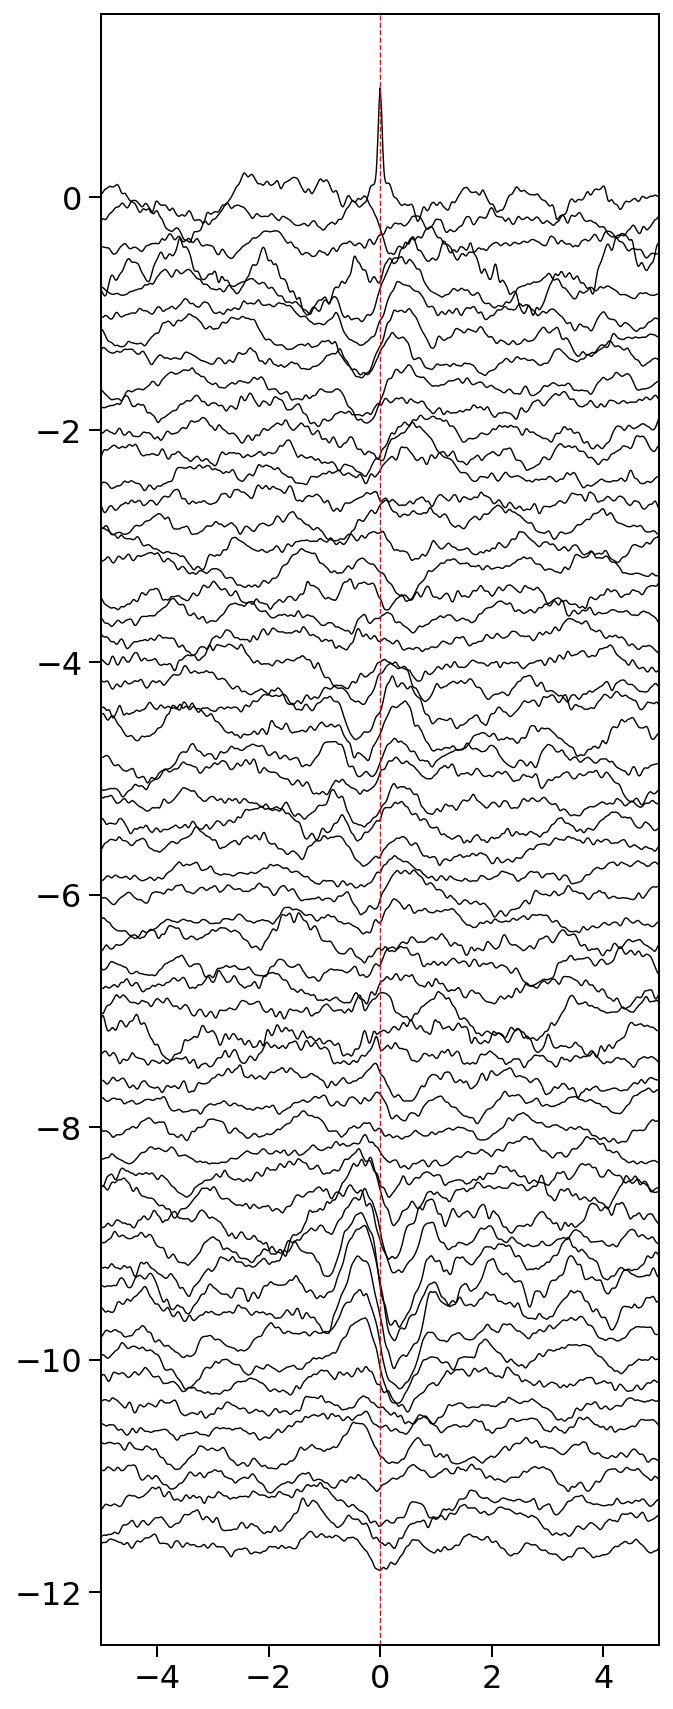

In [28]:
plt.figure(figsize=[5,15])

for i, j in enumerate(interp.T):
    acor = np.correlate(interp.T[0] - 1., j - med, mode='full')
    df = template[1] - template[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    plt.plot(lags, acor - i*0.2, linewidth=0.7, c='black');
    
plt.xlim(-5,5)
plt.axvline(0., c='r', linestyle='dashed', lw=0.7)

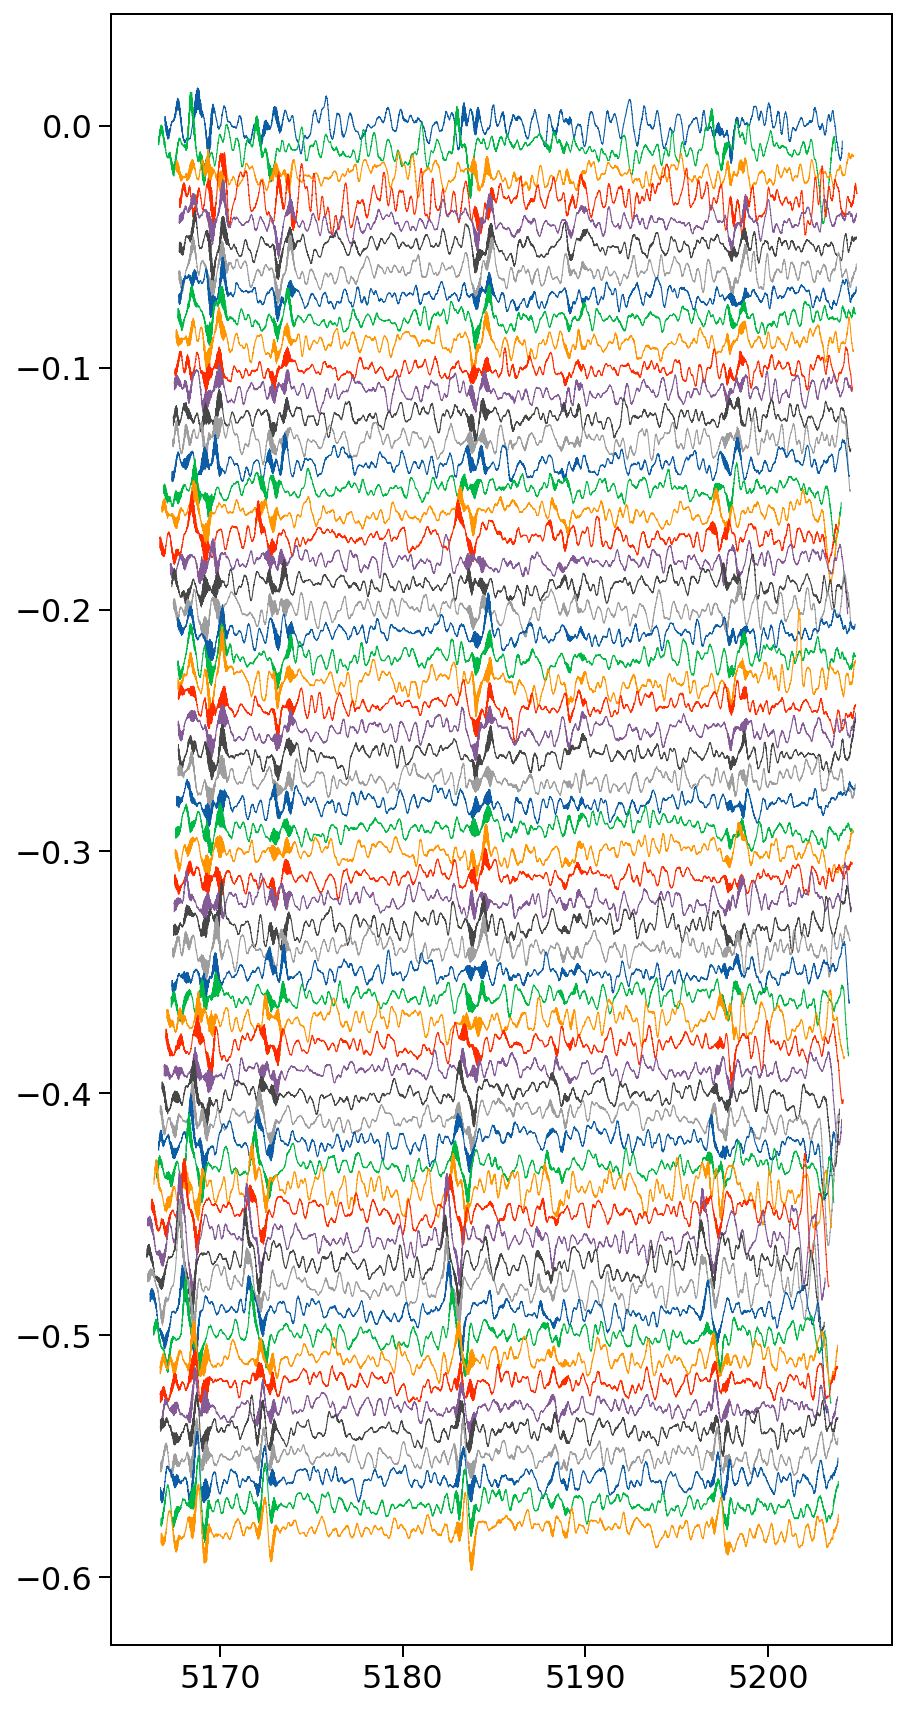

In [97]:
plt.figure(figsize=[7,15])

test = []
for i, j in enumerate(interp.T):
    ww = template - wav_shifts[m][i]
    plt.plot(ww, j - med - i*0.01, lw=0.5)
    
    m2 = (ww > 5170) & (ww < 5200)
    test.append(j[m2] - med[m2])
    
test = np.array(test)

In [104]:
test

array([[-0.00056061, -0.00030223, -0.00030223, ...,  0.00771406,
         0.00771406,  0.00771406],
       [ 0.00635817,  0.00635817,  0.00635817, ...,  0.00320833,
         0.00321518,  0.00339262],
       [-0.00658059,  0.00078289,  0.00033792, ..., -0.00365581,
        -0.00365581, -0.00365581],
       ...,
       [-0.00557803, -0.00557803, -0.00557803, ..., -0.00070549,
        -0.00070549, -0.00067733],
       [-0.00082424, -0.00082424, -0.00078141, ..., -0.0021684 ,
        -0.00219275, -0.00210688],
       [-0.00248953, -0.00248953, -0.00248953, ..., -0.00337305,
        -0.00333205, -0.0033564 ]])

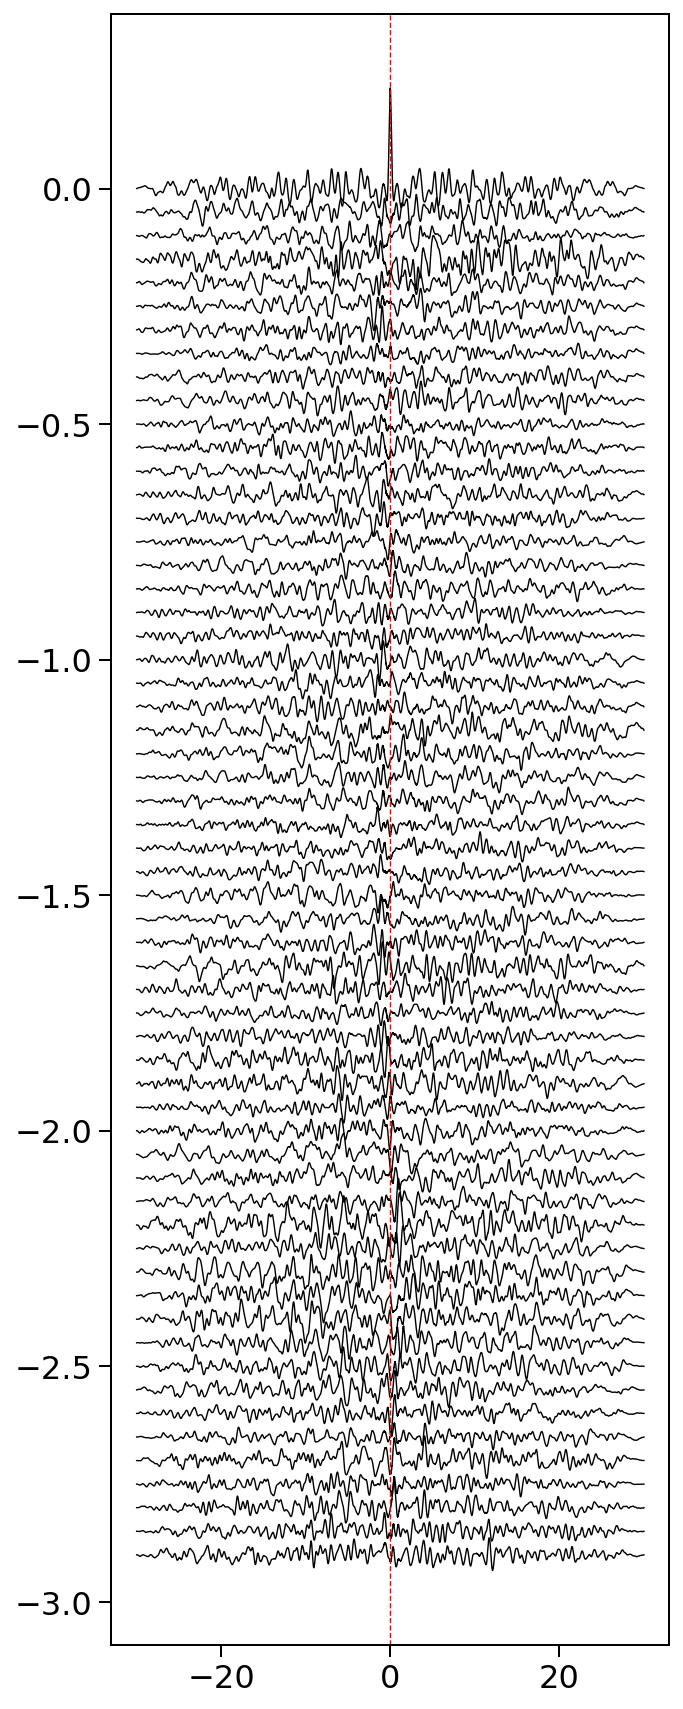

In [108]:
plt.figure(figsize=[5,15])

for i, j in enumerate(test):
    acor = np.correlate(test[0], j, mode='full')
    df = template[1] - template[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    plt.plot(lags, acor - i*0.05, linewidth=0.7, c='black');
    
# plt.xlim(-2,2)
plt.axvline(0., c='r', linestyle='dashed', lw=0.7)

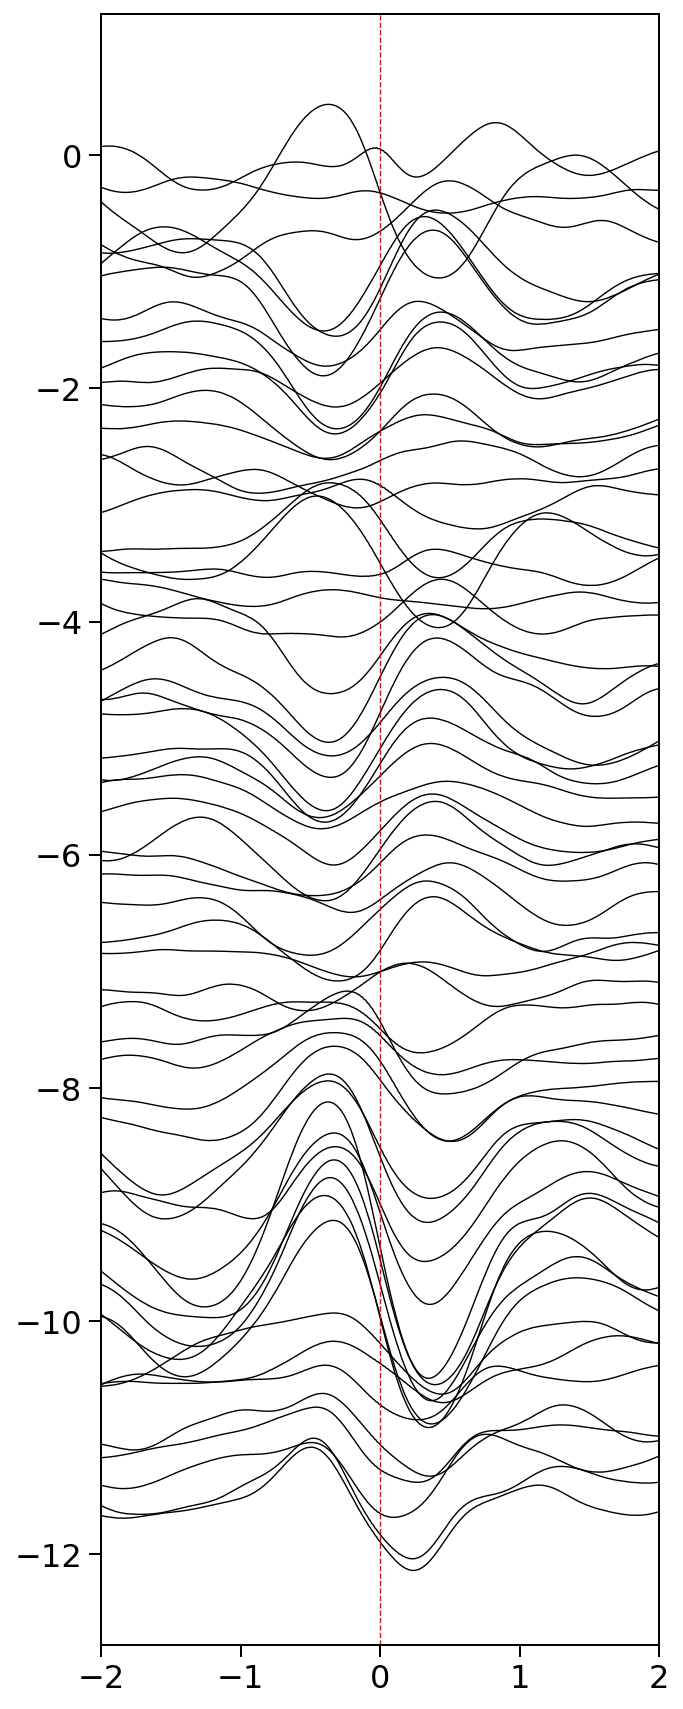

In [65]:
plt.figure(figsize=[5,15])

for i, j in enumerate(interp.T):
    acor = np.correlate(interp.T[0] - 1., j - med, mode='full')
    df = template[1] - template[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    plt.plot(lags, acor - i*0.2, linewidth=0.7, c='black');
    
plt.xlim(-2,2)
plt.axvline(0., c='r', linestyle='dashed', lw=0.7)

In [35]:
porb = 51.4213

phase_secondary = [0.48, 0.492]
phase_primary = [0.73, 0.745]
phase_times = np.array(obs_times) % porb / porb

m_secondary = (phase_times < phase_secondary[1]) & (phase_times > phase_secondary[0])
m_primary = (phase_times < phase_primary[1]) & (phase_times > phase_primary[0])
m_outofeclipse = (~m_primary) & (~m_secondary)

In [36]:
wav_shifts = np.array([-0.0915913 ,  0.26033683, -0.70038709, -0.89535692, -0.86997843,
       -0.87075478, -0.85851908, -0.85506095, -0.80112998, -0.70679285,
       -0.64066379, -0.60620508, -0.55608518, -0.5216322 , -0.47436319,
       -0.41779333, -0.03116966,  0.07333483,  0.18058427, -0.38657061,
       -0.47358921, -0.5508825 , -0.79386422, -0.80052327, -0.81174071,
       -0.82330738, -0.81752276, -0.82187655, -0.80853981, -0.73807956,
       -0.68639732, -0.65227823, -0.62923657, -0.59946752, -0.56398004,
       -0.51981331, -0.475165  , -0.43736705, -0.20198662, -0.14237736,
       -0.05088621,  0.06847369,  0.17048313,  0.25504151,  0.37591421,
        0.50627662,  0.64576925,  0.84853629,  0.89659549,  0.84427746,
        0.71600074,  0.5307709 ,  0.16787024,  0.1628877 ,  0.15926703,
        0.1508248 ,  0.15159962,  0.14430931,  0.12417134,  0.12228407,
        0.086027  ]);

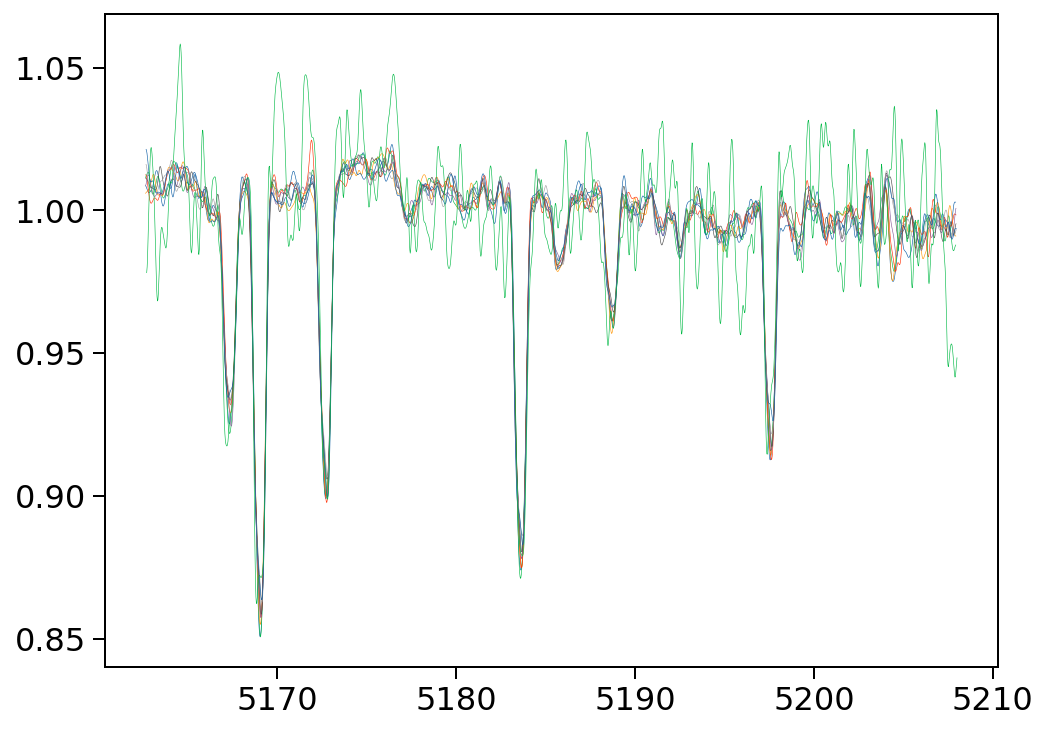

In [26]:
primary = np.arange(len(m_primary))[m_primary]
wav, flux = vs.correct(epochs=primary, orders=[22], offset=wav_shifts[m_primary], smooth_factor=0.1, flatten_factor=1)
plt.plot(wav, flux, lw=0.3);
# plt.xlim(5016, 5020)

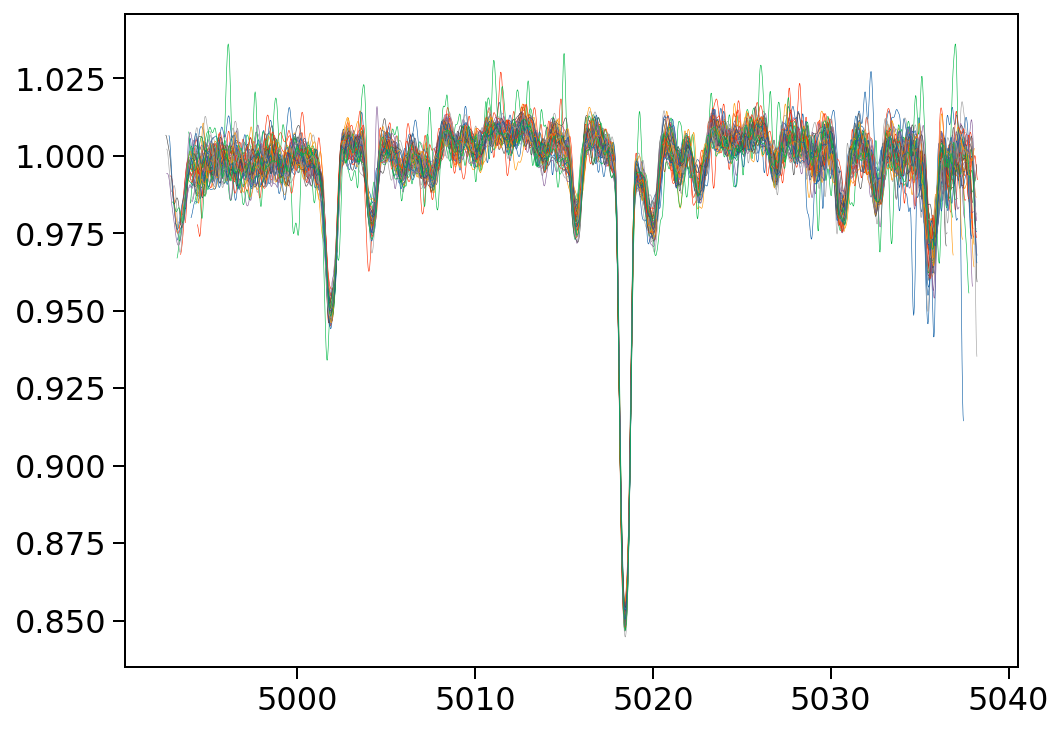

In [14]:
secondary = np.arange(len(m_outofeclipse))[m_outofeclipse]
wav, flux = vs.correct(epochs=secondary, orders=[18], offset=wav_shifts[m_outofeclipse], smooth_factor=0.1, flatten_factor=1)
plt.plot(wav, flux, lw=0.3);

(5016.0, 5020.0)

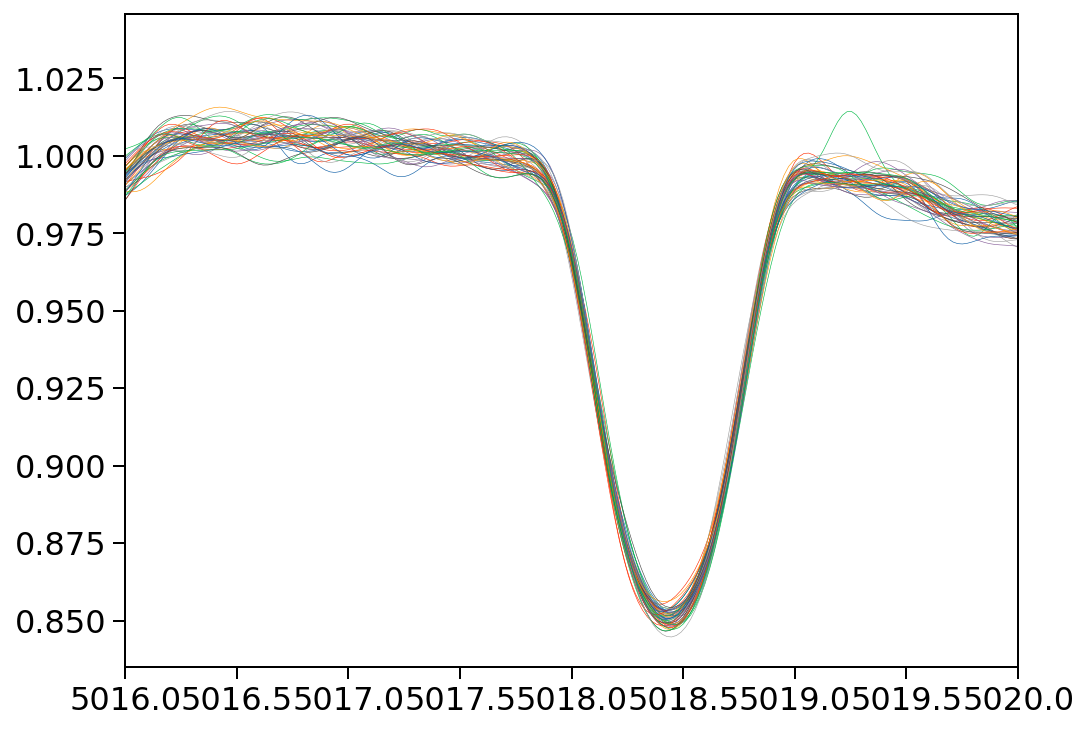

In [19]:
plt.plot(wav, flux, lw=0.3);
plt.xlim(5016, 5020)